In [ ]:
from google.colab import auth
auth.authenticate_user()

!pip install -q google-cloud-bigquery

from google.cloud import bigquery

# IMPORTANT: this must be YOUR project, not physionet-data
PROJECT_ID = "mimic-thesis"  # e.g. "ola-mimic-thesis-123456"
client = bigquery.Client(project=PROJECT_ID)


In [ ]:
query = """
SELECT subject_id, gender, anchor_age, anchor_year
FROM `physionet-data.mimiciv_3_1_hosp.patients`
LIMIT 10
"""
df = client.query(query).to_dataframe()
df.head()


,subject_id,gender,anchor_age,anchor_year
0,10078138,F,18,2110
1,10180372,M,18,2110
2,10686175,M,18,2110
3,10851602,F,18,2110
4,10902424,F,18,2110


In [ ]:
query = """
-- 1) ED stays backbone with arrival time + basic demographics
WITH ed AS (
  SELECT
    subject_id,
    hadm_id,
    stay_id,
    intime AS arrival_time,
    gender,
    race
  FROM `physionet-data.mimiciv_ed.edstays`
),

-- 2) Triage snapshot (one row per stay_id, early vitals + acuity)
tri AS (
  SELECT
    subject_id,
    stay_id,
    temperature,
    heartrate,
    resprate,
    o2sat,
    sbp,
    dbp,
    pain,
    acuity,
    chiefcomplaint
  FROM `physionet-data.mimiciv_ed.triage`
),

-- 3) Demographics (age)
pats AS (
  SELECT
    subject_id,
    anchor_age
  FROM `physionet-data.mimiciv_3_1_hosp.patients`
),

-- 4) ICU stays to get ICU-within-24h label
icu AS (
  SELECT
    subject_id,
    hadm_id,
    intime AS icu_intime
  FROM `physionet-data.mimiciv_3_1_icu.icustays`
)

-- 5) Final ED triage cohort
SELECT
  ed.subject_id,
  ed.hadm_id,
  ed.stay_id,
  ed.gender,
  ed.race,
  p.anchor_age,
  ed.arrival_time,
  tri.temperature,
  tri.heartrate,
  tri.resprate,
  tri.o2sat,
  tri.sbp,
  tri.dbp,
  tri.pain,
  tri.acuity,
  tri.chiefcomplaint,
  icu.icu_intime,
  CASE
    WHEN icu.icu_intime IS NOT NULL
     AND DATETIME_DIFF(icu.icu_intime, ed.arrival_time, HOUR)
         BETWEEN 0 AND 24
    THEN 1 ELSE 0
  END AS icu_24h
FROM ed
LEFT JOIN tri
  ON ed.subject_id = tri.subject_id
 AND ed.stay_id   = tri.stay_id
LEFT JOIN pats p
  ON ed.subject_id = p.subject_id
LEFT JOIN icu
  ON ed.subject_id = icu.subject_id
 AND ed.hadm_id   = icu.hadm_id
WHERE ed.arrival_time IS NOT NULL
LIMIT 50000
"""

df = client.query(query).to_dataframe()
df.head(), df.columns


(   subject_id   hadm_id   stay_id gender   race  anchor_age  \
 0    10000178      <NA>  31721172      F  ASIAN          59   
 1    10004371      <NA>  38482952      F  ASIAN          42   
 2    10005303      <NA>  32459569      M  ASIAN          28   
 3    10005329  25902419  32044805      F  ASIAN          27   
 4    10009866      <NA>  37316180      M  ASIAN          28   
 
          arrival_time   temperature     heartrate      resprate  \
 0 2157-04-08 09:58:00  98.500000000  82.000000000  16.000000000   
 1 2182-05-14 14:08:00  99.200000000  88.000000000  18.000000000   
 2 2135-07-05 12:10:00  98.000000000  96.000000000  18.000000000   
 3 2138-08-11 19:09:00  98.000000000  82.000000000  18.000000000   
 4 2123-01-28 16:36:00  98.100000000  77.000000000  16.000000000   
 
            o2sat            sbp           dbp pain       acuity  \
 0  100.000000000  167.000000000  86.000000000    8  3.000000000   
 1  100.000000000  154.000000000  91.000000000    3  3.000000000   


In [ ]:
import pandas as pd
import numpy as np

df_clean = df.copy()

# ---- Convert categorical ----
df_clean['gender'] = df_clean['gender'].astype('category')
df_clean['race']   = df_clean['race'].astype('category')

# ---- Convert datetimes ----
df_clean['arrival_time'] = pd.to_datetime(df_clean['arrival_time'])
df_clean['icu_intime']   = pd.to_datetime(df_clean['icu_intime'])

# ---- Convert numeric-like strings to numeric ----
num_like_cols = ['temperature','heartrate','resprate','o2sat',
                 'sbp','dbp','pain','acuity']

for col in num_like_cols:
    df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')

# ---- Time-to-ICU engineered feature ----
df_clean['time_to_icu_hours'] = (
    (df_clean['icu_intime'] - df_clean['arrival_time'])
    .dt.total_seconds() / 3600
)
df_clean['time_to_icu_hours'] = df_clean['time_to_icu_hours'].fillna(999)

# ---- Drop rows missing target ----
df_clean = df_clean.dropna(subset=['icu_24h'])

# ---- Impute numeric columns ----
for col in num_like_cols:
    df_clean[col] = df_clean[col].fillna(df_clean[col].median())

# ---- One-hot encode categories ----
df_model = pd.get_dummies(df_clean,
                          columns=['gender','race'],
                          drop_first=True)

# ---- Drop columns not used for training ----
df_model = df_model.drop(columns=['subject_id','stay_id','hadm_id',
                                  'chiefcomplaint','arrival_time','icu_intime'])

df_model.head()


,anchor_age,temperature,heartrate,resprate,o2sat,sbp,dbp,pain,acuity,icu_24h,time_to_icu_hours,gender_M,race_OTHER,race_WHITE
0,59,98.5,82.0,16.0,100.0,167.0,86.0,8.0,3.0,0,999.0,False,False,False
1,42,99.2,88.0,18.0,100.0,154.0,91.0,3.0,3.0,0,999.0,False,False,False
2,28,98.0,96.0,18.0,100.0,142.0,99.0,7.0,4.0,0,999.0,True,False,False
3,27,98.0,82.0,18.0,100.0,122.0,82.0,0.0,3.0,0,999.0,False,False,False
4,28,98.1,77.0,16.0,99.0,121.0,79.0,7.0,3.0,0,999.0,True,False,False


In [ ]:
query = """
WITH ed_base AS (
  SELECT
    e.subject_id,
    e.hadm_id,
    e.stay_id,
    e.intime AS arrival_time,
    p.anchor_age,
    p.gender,
    e.race
  FROM `physionet-data.mimiciv_ed.edstays` AS e
  LEFT JOIN `physionet-data.mimiciv_3_1_hosp.patients` AS p
    USING (subject_id)
),

early_vitals AS (
  SELECT
    v.subject_id,
    v.stay_id,
    -- example: median vitals in first 2 hours
    AVG(v.temperature) AS temp_mean_2h,
    AVG(v.heartrate)   AS hr_mean_2h,
    AVG(v.resprate)    AS rr_mean_2h,
    AVG(v.o2sat)       AS o2_mean_2h,
    AVG(v.sbp)         AS sbp_mean_2h,
    AVG(v.dbp)         AS dbp_mean_2h
  FROM `physionet-data.mimiciv_ed.vitalsign` AS v
  JOIN `physionet-data.mimiciv_ed.edstays`   AS e
    ON v.subject_id = e.subject_id
   AND v.stay_id    = e.stay_id
   AND v.charttime BETWEEN e.intime
                       AND DATETIME_ADD(e.intime, INTERVAL 2 HOUR)
  GROUP BY v.subject_id, v.stay_id
),

icu_flag AS (
  SELECT
    hadm_id,
    MIN(intime) AS first_icu_intime
  FROM `physionet-data.mimiciv_3_1_icu.icustays`
  GROUP BY hadm_id
)

SELECT
  b.*,
  ev.* EXCEPT(subject_id, stay_id),
  i.first_icu_intime AS icu_intime,
  CASE
    WHEN i.first_icu_intime IS NOT NULL
         AND DATETIME_DIFF(i.first_icu_intime, b.arrival_time, HOUR) <= 24
    THEN 1 ELSE 0
  END AS icu_24h
FROM ed_base b
LEFT JOIN early_vitals ev
  USING (subject_id, stay_id)
LEFT JOIN icu_flag i
  USING (hadm_id);


"""

df = client.query(query).to_dataframe()
df.head()


,subject_id,hadm_id,stay_id,arrival_time,anchor_age,gender,race,temp_mean_2h,hr_mean_2h,rr_mean_2h,o2_mean_2h,sbp_mean_2h,dbp_mean_2h,icu_intime,icu_24h
0,10189282,<NA>,30902921,2142-12-19 16:41:00,48,M,ASIAN,98.150000000,78.000000000,19.500000000,100.000000000,167.0,94.000000,NaT,0
1,10215284,26214844,39552302,2148-04-30 03:15:00,66,M,ASIAN,None,90.000000000,14.400000000,98.200000000,129.8,76.600000,NaT,0
2,10225660,<NA>,34749461,2146-02-16 06:33:00,23,F,ASIAN,None,78.666666667,15.333333333,99.000000000,122.0,77.333333,NaT,0
3,10299240,<NA>,37968243,2127-04-12 09:11:00,41,F,ASIAN,None,124.000000000,26.000000000,None,NaN,NaN,NaT,0
4,10302972,<NA>,30909106,2167-07-17 17:35:00,53,F,ASIAN,97.600000000,80.000000000,19.333333333,99.000000000,133.0,70.666667,NaT,0


In [ ]:
len(df)


425087

In [ ]:
import pandas as pd
import numpy as np

df_model = df.copy()

# --- 1. Keep only rows with valid label ---
df_model = df_model[df_model['icu_24h'].notna()].copy()
df_model['icu_24h'] = df_model['icu_24h'].astype(int)

# --- 2. Coerce vitals to numeric ---
vital_cols = ['temp_mean_2h','hr_mean_2h','rr_mean_2h',
              'o2_mean_2h','sbp_mean_2h','dbp_mean_2h']

for col in vital_cols:
    df_model[col] = pd.to_numeric(df_model[col], errors='coerce')

# Drop rows where ALL vitals are missing
df_model = df_model.dropna(subset=vital_cols, how='all').copy()

# Median impute remaining missing vitals
for col in vital_cols:
    median_val = df_model[col].median()
    df_model[col] = df_model[col].fillna(median_val)

# --- 3. Race grouping (ASIAN / BLACK / WHITE / HISPANIC / OTHER) ---
def map_race(r):
    if pd.isna(r):
        return 'OTHER'
    r = str(r).upper()
    if 'WHITE' in r:
        return 'WHITE'
    if 'BLACK' in r:
        return 'BLACK'
    if 'ASIAN' in r:
        return 'ASIAN'
    if 'HISPANIC' in r or 'LATINO' in r:
        return 'HISPANIC'
    return 'OTHER'

df_model['race_group'] = df_model['race'].apply(map_race)

# --- 4. Basic sanity check ---
print("Label balance:")
print(df_model['icu_24h'].value_counts(normalize=True))

df_model.head()


Label balance:
icu_24h
0    0.926065
1    0.073935
Name: proportion, dtype: float64


,subject_id,hadm_id,stay_id,arrival_time,anchor_age,gender,race,temp_mean_2h,hr_mean_2h,rr_mean_2h,o2_mean_2h,sbp_mean_2h,dbp_mean_2h,icu_intime,icu_24h,race_group
0,10189282,<NA>,30902921,2142-12-19 16:41:00,48,M,ASIAN,98.15,78.000000,19.500000,100.0,167.0,94.000000,NaT,0,ASIAN
1,10215284,26214844,39552302,2148-04-30 03:15:00,66,M,ASIAN,98.00,90.000000,14.400000,98.2,129.8,76.600000,NaT,0,ASIAN
2,10225660,<NA>,34749461,2146-02-16 06:33:00,23,F,ASIAN,98.00,78.666667,15.333333,99.0,122.0,77.333333,NaT,0,ASIAN
3,10299240,<NA>,37968243,2127-04-12 09:11:00,41,F,ASIAN,98.00,124.000000,26.000000,99.0,131.0,76.000000,NaT,0,ASIAN
4,10302972,<NA>,30909106,2167-07-17 17:35:00,53,F,ASIAN,97.60,80.000000,19.333333,99.0,133.0,70.666667,NaT,0,ASIAN


In [ ]:
len(df_model)

299398

#Visualising Data

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="whitegrid")

print("df_model shape:", df_model.shape)
print("\nColumns:", df_model.columns.tolist())

print("\nICU 24h label balance:")
print(df_model["icu_24h"].value_counts())
print("\nICU 24h label proportion:")
print(df_model["icu_24h"].value_counts(normalize=True))


df_model shape: (299398, 16)

Columns: ['subject_id', 'hadm_id', 'stay_id', 'arrival_time', 'anchor_age', 'gender', 'race', 'temp_mean_2h', 'hr_mean_2h', 'rr_mean_2h', 'o2_mean_2h', 'sbp_mean_2h', 'dbp_mean_2h', 'icu_intime', 'icu_24h', 'race_group']

ICU 24h label balance:
icu_24h
0    277262
1     22136
Name: count, dtype: int64

ICU 24h label proportion:
icu_24h
0    0.926065
1    0.073935
Name: proportion, dtype: float64


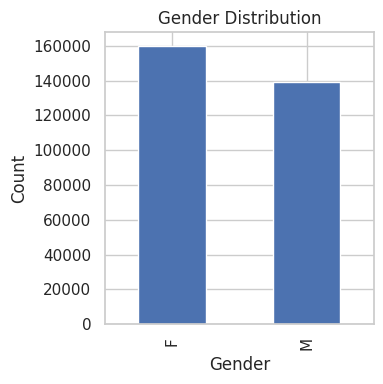

In [ ]:
plt.figure(figsize=(4,4))
df_model["gender"].value_counts().plot(kind="bar")
plt.title("Gender Distribution")
plt.xlabel("Gender")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


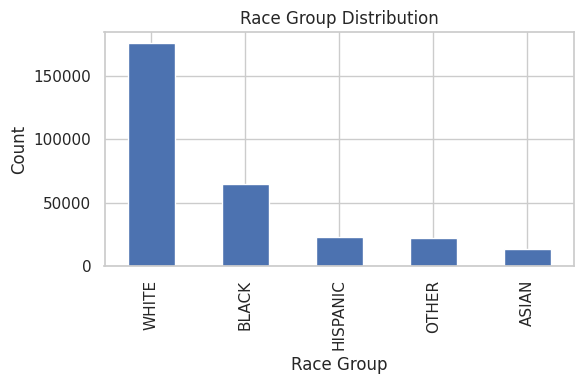

In [ ]:
plt.figure(figsize=(6,4))
df_model["race_group"].value_counts().plot(kind="bar")
plt.title("Race Group Distribution")
plt.xlabel("Race Group")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


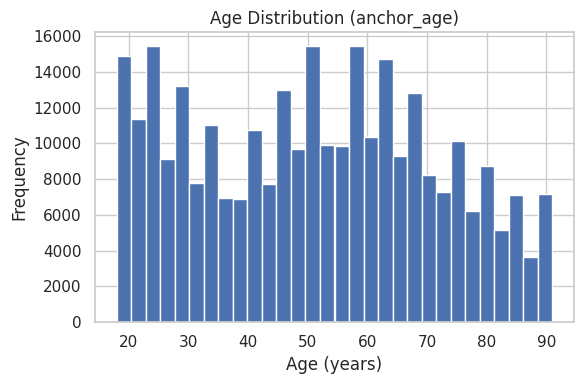

In [ ]:
plt.figure(figsize=(6,4))
df_model["anchor_age"].dropna().plot(kind="hist", bins=30)
plt.title("Age Distribution (anchor_age)")
plt.xlabel("Age (years)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


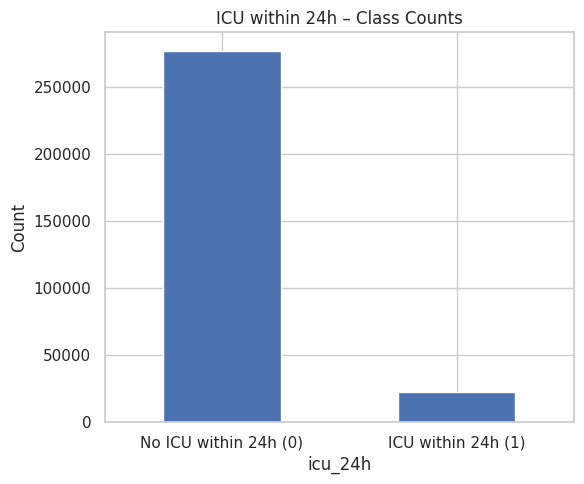

In [ ]:
plt.figure(figsize=(6,5))
df_model["icu_24h"].value_counts().sort_index().plot(
    kind="bar"
)
plt.title("ICU within 24h – Class Counts")
plt.xticks([0,1], ["No ICU within 24h (0)", "ICU within 24h (1)"], rotation=0)
plt.ylabel("Count")
plt.tight_layout()
plt.show()


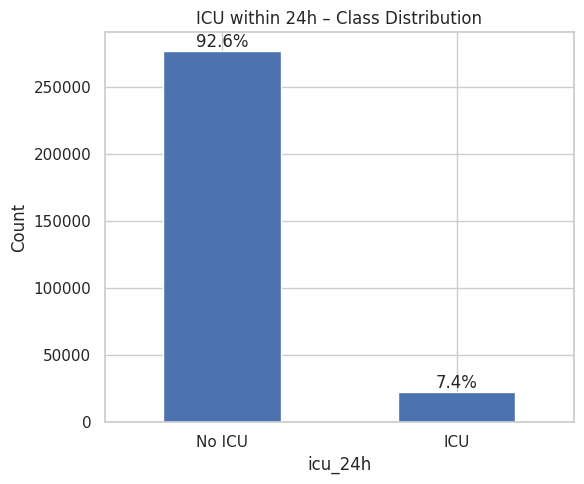

In [ ]:
counts = df_model["icu_24h"].value_counts()
props  = df_model["icu_24h"].value_counts(normalize=True)

plt.figure(figsize=(6,5))
ax = counts.sort_index().plot(kind="bar")
plt.title("ICU within 24h – Class Distribution")
plt.xticks([0,1], ["No ICU", "ICU"], rotation=0)
plt.ylabel("Count")

for i, (c, p) in enumerate(zip(counts.sort_index(), props.sort_index())):
    ax.text(i, c, f"{p*100:.1f}%", ha="center", va="bottom")

plt.tight_layout()
plt.show()


Vitals available for plotting: ['temp_mean_2h', 'hr_mean_2h', 'rr_mean_2h', 'o2_mean_2h', 'sbp_mean_2h', 'dbp_mean_2h']


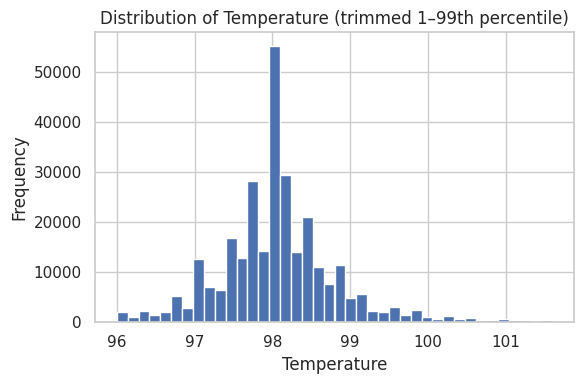

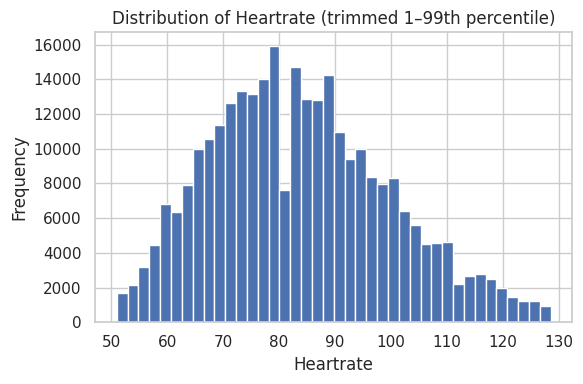

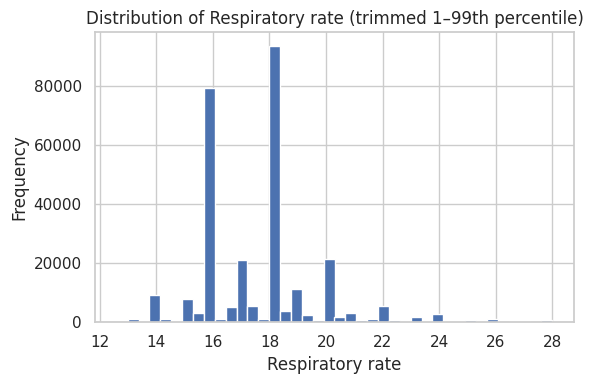

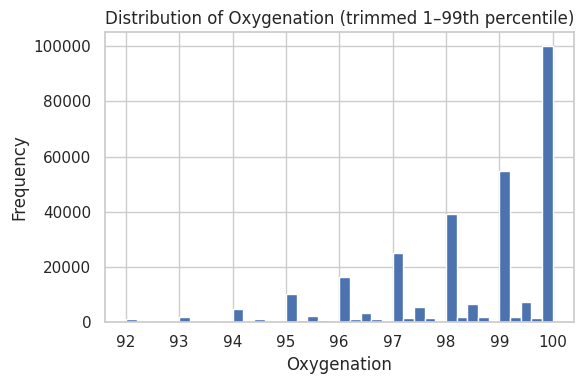

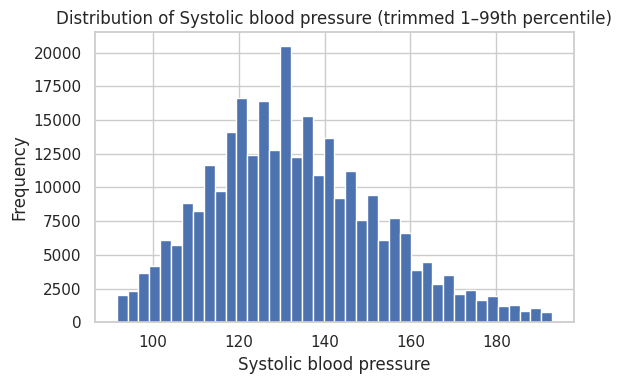

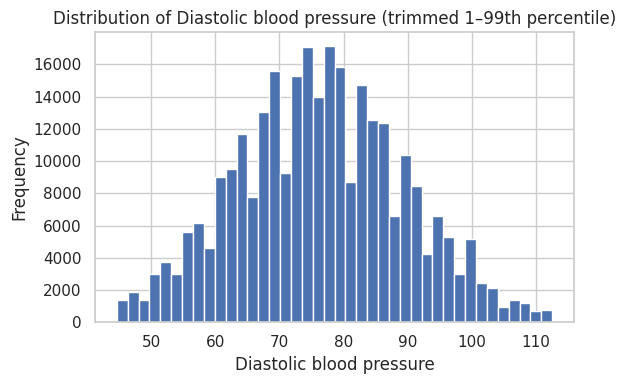

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

vital_cols = ['temp_mean_2h','hr_mean_2h','rr_mean_2h',
              'o2_mean_2h','sbp_mean_2h','dbp_mean_2h']

name_cols = ['Temperature','Heartrate','Respiratory rate',
             'Oxygenation','Systolic blood pressure','Diastolic blood pressure']

# Keep only the vitals present in df_model
vital_cols = [c for c in vital_cols if c in df_model.columns]

# Build a mapping: column_name -> readable_name
name_map = dict(zip(
    ['temp_mean_2h','hr_mean_2h','rr_mean_2h','o2_mean_2h','sbp_mean_2h','dbp_mean_2h'],
    name_cols
))

print("Vitals available for plotting:", vital_cols)

for col in vital_cols:
    readable = name_map.get(col, col)

    vals = df_model[col].dropna().values.astype(float)
    low, high = np.percentile(vals, [1, 99])
    trimmed = vals[(vals >= low) & (vals <= high)]

    plt.figure(figsize=(6,4))
    plt.hist(trimmed, bins=40)
    plt.title(f"Distribution of {readable} (trimmed 1–99th percentile)")
    plt.xlabel(readable)
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()



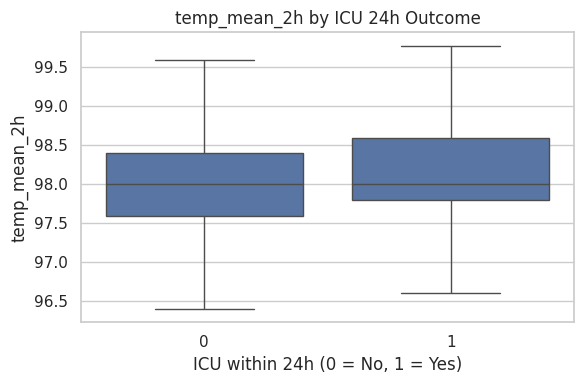

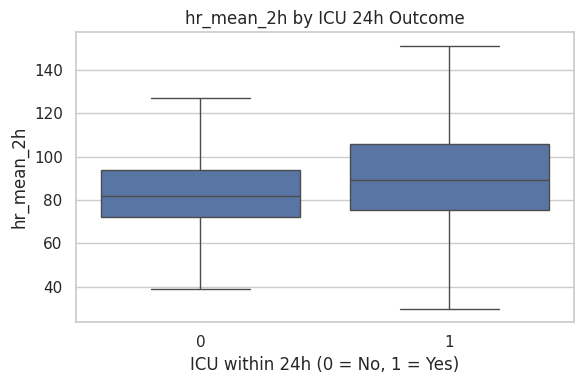

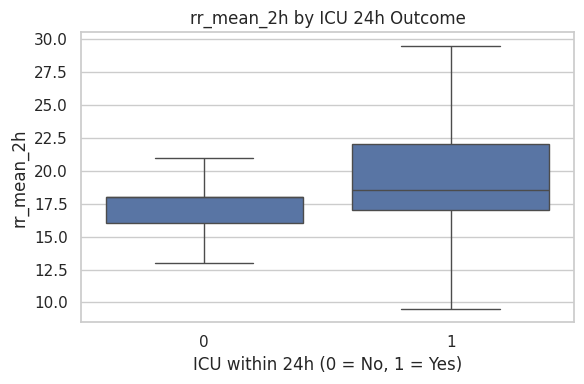

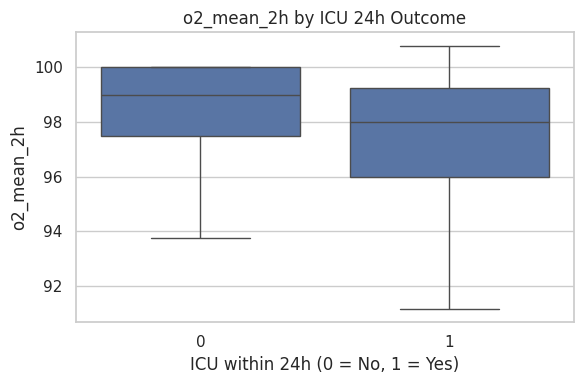

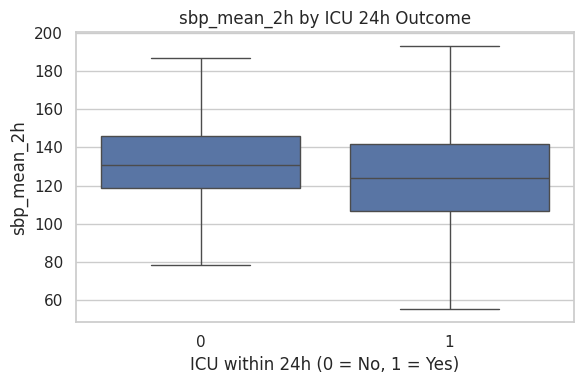

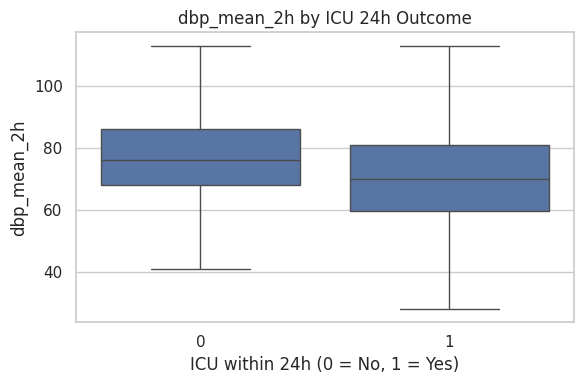

In [ ]:
for col in vital_cols:
    plt.figure(figsize=(6,4))
    sns.boxplot(
        x="icu_24h",
        y=col,
        data=df_model,
        showfliers=False
    )
    plt.title(f"{col} by ICU 24h Outcome")
    plt.xlabel("ICU within 24h (0 = No, 1 = Yes)")
    plt.ylabel(col)
    plt.tight_layout()
    plt.show()


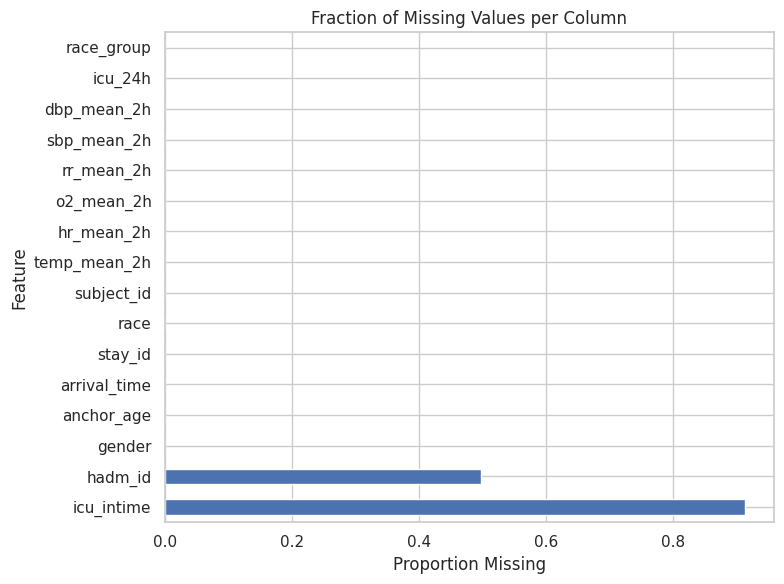

In [ ]:
missing_frac = df_model.isna().mean().sort_values(ascending=False)

plt.figure(figsize=(8,6))
missing_frac.plot(kind="barh")
plt.title("Fraction of Missing Values per Column")
plt.xlabel("Proportion Missing")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


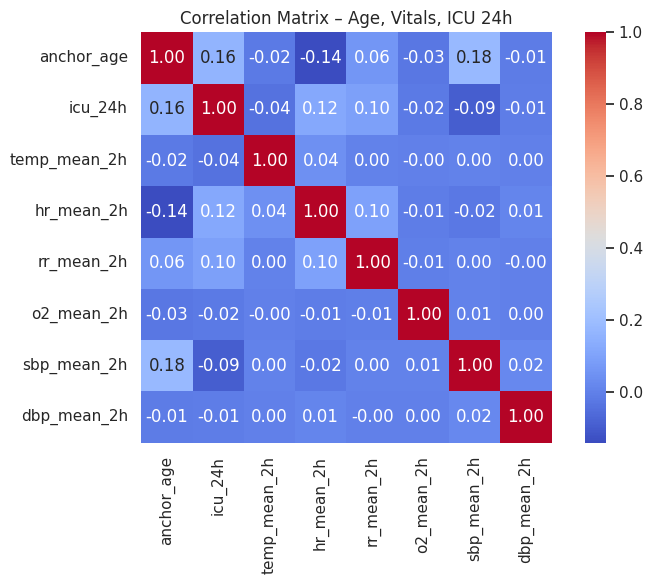

In [ ]:
num_cols = ["anchor_age","icu_24h"] + vital_cols
num_cols = [c for c in num_cols if c in df_model.columns]

corr = df_model[num_cols].corr()

plt.figure(figsize=(8,6))
sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    square=True
)
plt.title("Correlation Matrix – Age, Vitals, ICU 24h")
plt.tight_layout()
plt.show()


Mean vitals by ICU 24h group:
         temp_mean_2h  hr_mean_2h  rr_mean_2h  o2_mean_2h  sbp_mean_2h  \
icu_24h                                                                  
0           97.994434   83.334270   17.572403   98.441137   133.729742   
1           97.339809   91.168511   19.868490   97.308478   125.993003   

         dbp_mean_2h  
icu_24h               
0          78.795110  
1          72.107368  


<Figure size 1200x500 with 0 Axes>

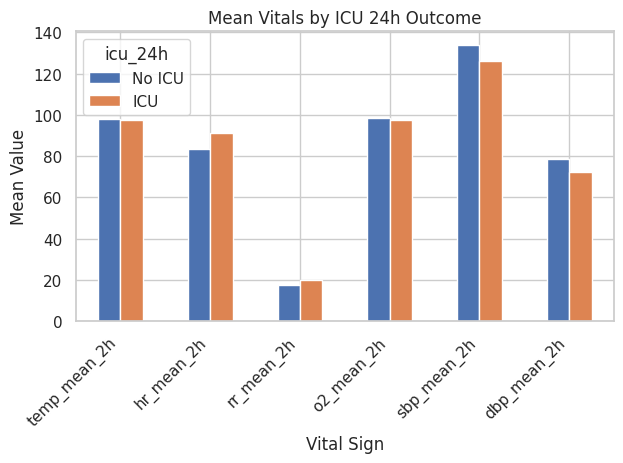

In [ ]:
group_means = df_model.groupby("icu_24h")[vital_cols].mean()
print("Mean vitals by ICU 24h group:")
print(group_means)

plt.figure(figsize=(12,5))
group_means.T.plot(kind="bar")
plt.title("Mean Vitals by ICU 24h Outcome")
plt.xlabel("Vital Sign")
plt.ylabel("Mean Value")
plt.xticks(rotation=45, ha="right")
plt.legend(title="icu_24h", labels=["No ICU", "ICU"])
plt.tight_layout()
plt.show()


In [ ]:
# Numeric features
num_cols = ['anchor_age'] + vital_cols

# Categorical → one-hot (drop first to avoid dummy trap)
cat_cols = ['gender', 'race_group']
X_cat = pd.get_dummies(df_model[cat_cols], drop_first=True)

X_num = df_model[num_cols].copy()
X = pd.concat([X_num, X_cat], axis=1)

y = df_model['icu_24h'].astype(int)

print("X shape:", X.shape)
print("y positive rate:", y.mean())
X.head()


X shape: (299398, 12)
y positive rate: 0.07393502962611641


,anchor_age,temp_mean_2h,hr_mean_2h,rr_mean_2h,o2_mean_2h,sbp_mean_2h,dbp_mean_2h,gender_M,race_group_BLACK,race_group_HISPANIC,race_group_OTHER,race_group_WHITE
0,48,98.15,78.000000,19.500000,100.0,167.0,94.000000,True,False,False,False,False
1,66,98.00,90.000000,14.400000,98.2,129.8,76.600000,True,False,False,False,False
2,23,98.00,78.666667,15.333333,99.0,122.0,77.333333,False,False,False,False,False
3,41,98.00,124.000000,26.000000,99.0,131.0,76.000000,False,False,False,False,False
4,53,97.60,80.000000,19.333333,99.0,133.0,70.666667,False,False,False,False,False


In [ ]:
from sklearn.model_selection import train_test_split

# 70% train, 15% val, 15% test – all stratified by label
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y,
    test_size=0.30,
    stratify=y,
    random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.50,
    stratify=y_temp,
    random_state=42
)

def show_balance(name, y_vec):
    print(f"{name} class balance:")
    print(y_vec.value_counts(normalize=True))

show_balance("TRAIN", y_train)
show_balance("VAL", y_val)
show_balance("TEST", y_test)


TRAIN class balance:
icu_24h
0    0.926066
1    0.073934
Name: proportion, dtype: float64
VAL class balance:
icu_24h
0    0.926052
1    0.073948
Name: proportion, dtype: float64
TEST class balance:
icu_24h
0    0.926074
1    0.073926
Name: proportion, dtype: float64


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_val_scaled   = X_val.copy()
X_test_scaled  = X_test.copy()

X_train_scaled[num_cols] = scaler.fit_transform(X_train[num_cols])
X_val_scaled[num_cols]   = scaler.transform(X_val[num_cols])
X_test_scaled[num_cols]  = scaler.transform(X_test[num_cols])


In [ ]:
# Check NaNs across the finished design matrix
na_counts = X_train_scaled.isna().sum()
print(na_counts[na_counts > 0])


Series([], dtype: int64)


In [ ]:
# After X = pd.concat([X_num, X_cat], axis=1)

# 1) Handle numeric NaNs with median
num_cols_all = X.select_dtypes(include=['float64','float32','int64','Int64']).columns
for col in num_cols_all:
    med = X[col].median()
    X[col] = X[col].fillna(med)

# 2) Handle boolean / categorical leftovers just in case
bool_cols_all = X.select_dtypes(include=['bool']).columns
for col in bool_cols_all:
    X[col] = X[col].fillna(False)

# Final safety check
print("Total NaNs remaining in X:", int(X.isna().sum().sum()))


Total NaNs remaining in X: 0


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, average_precision_score, classification_report

def evaluate(name, model, X_v, y_v, X_te, y_te):
    # Validation
    proba_val = model.predict_proba(X_v)[:, 1]
    auroc_val = roc_auc_score(y_v, proba_val)
    auprc_val = average_precision_score(y_v, proba_val)
    print(f"{name} VAL  AUROC: {auroc_val:.3f}, AUPRC: {auprc_val:.3f}")

    # Test
    proba_te = model.predict_proba(X_te)[:, 1]
    auroc_te = roc_auc_score(y_te, proba_te)
    auprc_te = average_precision_score(y_te, proba_te)
    print(f"{name} TEST AUROC: {auroc_te:.3f}, AUPRC: {auprc_te:.3f}")

    print(f"\n{name} TEST classification report (threshold=0.5):")
    y_pred = model.predict(X_te)
    print(classification_report(y_te, y_pred, digits=3))
    print("="*70, "\n")

# ----- Logistic Regression -----
log_reg = LogisticRegression(
    max_iter=1000,
    class_weight='balanced',   # handle imbalance
    solver='liblinear'
)
log_reg.fit(X_train_scaled, y_train)
evaluate("LogReg", log_reg, X_val_scaled, y_val, X_test_scaled, y_test)

# ----- Random Forest -----
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)
evaluate("Random Forest", rf, X_val, y_val, X_test, y_test)

# ----- XGBoost -----
pos_weight = (y_train == 0).sum() / max((y_train == 1).sum(), 1)

xgb = XGBClassifier(
    n_estimators=400,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='binary:logistic',
    eval_metric='logloss',
    scale_pos_weight=pos_weight,
    n_jobs=-1,
    random_state=42
)
xgb.fit(X_train, y_train)
evaluate("XGBoost", xgb, X_val, y_val, X_test, y_test)


LogReg VAL  AUROC: 0.791, AUPRC: 0.298
LogReg TEST AUROC: 0.787, AUPRC: 0.306

LogReg TEST classification report (threshold=0.5):
              precision    recall  f1-score   support

           0      0.967     0.735     0.835     41590
           1      0.171     0.687     0.274      3320

    accuracy                          0.731     44910
   macro avg      0.569     0.711     0.555     44910
weighted avg      0.908     0.731     0.794     44910


Random Forest VAL  AUROC: 0.829, AUPRC: 0.364
Random Forest TEST AUROC: 0.830, AUPRC: 0.373

Random Forest TEST classification report (threshold=0.5):
              precision    recall  f1-score   support

           0      0.933     0.996     0.963     41590
           1      0.662     0.108     0.186      3320

    accuracy                          0.930     44910
   macro avg      0.798     0.552     0.575     44910
weighted avg      0.913     0.930     0.906     44910


XGBoost VAL  AUROC: 0.848, AUPRC: 0.399
XGBoost TEST AUROC: 0.8

In [ ]:
import numpy as np
import pandas as pd

# 1. Work on a copy
df = df_model.copy()

# 2. Drop rows with missing target
df = df[~df["icu_24h"].isna()].copy()
df["icu_24h"] = df["icu_24h"].astype(int)

# 3. Encode gender to binary (M=1, F=0)
df["gender_M"] = (df["gender"] == "M").astype(int)

# 4. One-hot encode race_group (ASIAN, WHITE, BLACK, OTHER, etc.)
df = pd.get_dummies(df, columns=["race_group"], drop_first=True)

# 5. Define feature columns
base_numeric = [
    "anchor_age",
    "temp_mean_2h",
    "hr_mean_2h",
    "rr_mean_2h",
    "o2_mean_2h",
    "sbp_mean_2h",
    "dbp_mean_2h",
]

race_dummy_cols = [c for c in df.columns if c.startswith("race_group_")]
feature_cols = base_numeric + ["gender_M"] + race_dummy_cols

target_col = "icu_24h"

# 6. Build X, y
X = df[feature_cols].copy()
y = df[target_col].copy()

X.head(), y.value_counts(normalize=True)


(   anchor_age  temp_mean_2h  hr_mean_2h  rr_mean_2h  o2_mean_2h  sbp_mean_2h  \
 0          48         98.15   78.000000   19.500000       100.0        167.0   
 1          66         98.00   90.000000   14.400000        98.2        129.8   
 2          23         98.00   78.666667   15.333333        99.0        122.0   
 3          41         98.00  124.000000   26.000000        99.0        131.0   
 4          53         97.60   80.000000   19.333333        99.0        133.0   
 
    dbp_mean_2h  gender_M  race_group_BLACK  race_group_HISPANIC  \
 0    94.000000         1             False                False   
 1    76.600000         1             False                False   
 2    77.333333         0             False                False   
 3    76.000000         0             False                False   
 4    70.666667         0             False                False   
 
    race_group_OTHER  race_group_WHITE  
 0             False             False  
 1             False

In [ ]:
df_model.columns

Index(['subject_id', 'hadm_id', 'stay_id', 'arrival_time', 'anchor_age',
       'gender', 'race', 'temp_mean_2h', 'hr_mean_2h', 'rr_mean_2h',
       'o2_mean_2h', 'sbp_mean_2h', 'dbp_mean_2h', 'icu_intime', 'icu_24h',
       'race_group'],
      dtype='object')

#Basic model plots

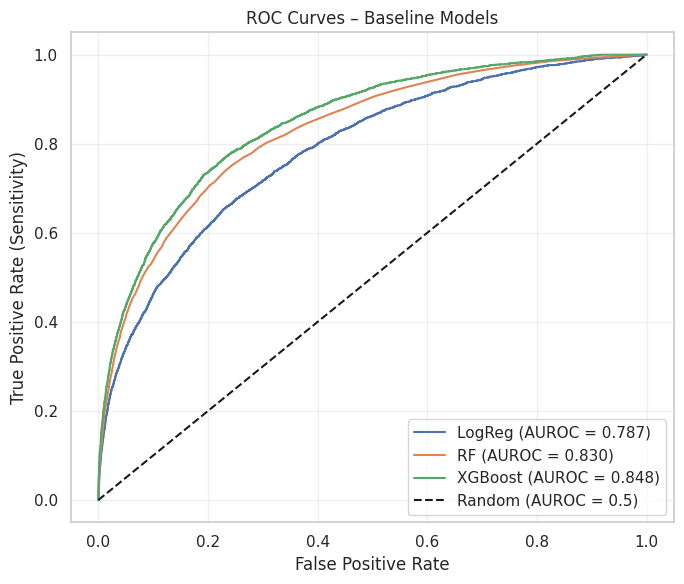

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# --- Get probabilities on TEST set ---
proba_log = log_reg.predict_proba(X_test_scaled)[:, 1]
proba_rf  = rf.predict_proba(X_test)[:, 1]
proba_xgb = xgb.predict_proba(X_test)[:, 1]

# --- Compute ROC curves ---
fpr_log, tpr_log, _ = roc_curve(y_test, proba_log)
fpr_rf,  tpr_rf,  _ = roc_curve(y_test, proba_rf)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, proba_xgb)

auc_log = roc_auc_score(y_test, proba_log)
auc_rf  = roc_auc_score(y_test, proba_rf)
auc_xgb = roc_auc_score(y_test, proba_xgb)

plt.figure(figsize=(7,6))
plt.plot(fpr_log, tpr_log, label=f"LogReg (AUROC = {auc_log:.3f})")
plt.plot(fpr_rf,  tpr_rf,  label=f"RF (AUROC = {auc_rf:.3f})")
plt.plot(fpr_xgb, tpr_xgb, label=f"XGBoost (AUROC = {auc_xgb:.3f})")

plt.plot([0,1], [0,1], 'k--', label="Random (AUROC = 0.5)")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Sensitivity)")
plt.title("ROC Curves – Baseline Models")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


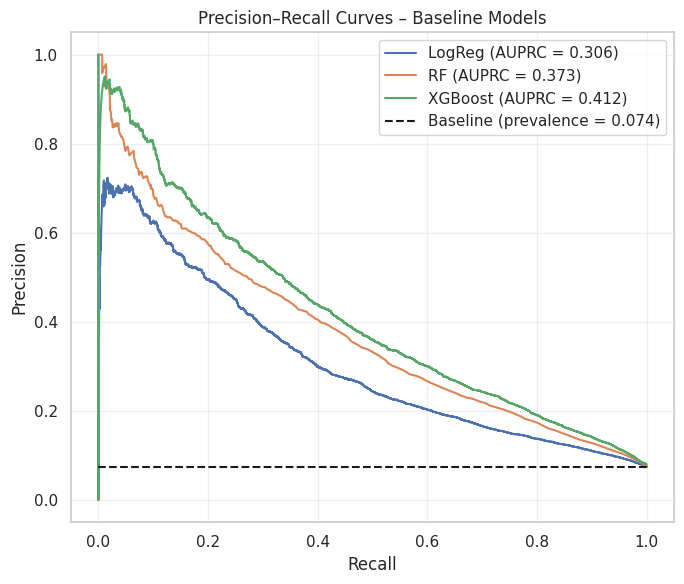

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score

prec_log, rec_log, _ = precision_recall_curve(y_test, proba_log)
prec_rf,  rec_rf,  _ = precision_recall_curve(y_test, proba_rf)
prec_xgb, rec_xgb, _ = precision_recall_curve(y_test, proba_xgb)

ap_log = average_precision_score(y_test, proba_log)
ap_rf  = average_precision_score(y_test, proba_rf)
ap_xgb = average_precision_score(y_test, proba_xgb)

baseline_pos_rate = y_test.mean()

plt.figure(figsize=(7,6))
plt.plot(rec_log, prec_log, label=f"LogReg (AUPRC = {ap_log:.3f})")
plt.plot(rec_rf,  prec_rf,  label=f"RF (AUPRC = {ap_rf:.3f})")
plt.plot(rec_xgb, prec_xgb, label=f"XGBoost (AUPRC = {ap_xgb:.3f})")

plt.hlines(baseline_pos_rate, 0, 1, colors='k', linestyles='--',
           label=f"Baseline (prevalence = {baseline_pos_rate:.3f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curves – Baseline Models")
plt.legend(loc="upper right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


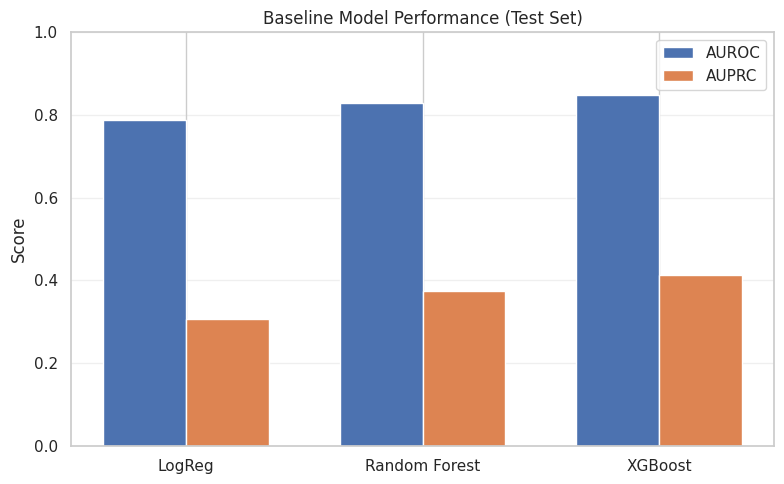

In [ ]:
import numpy as np

model_names = ["LogReg", "Random Forest", "XGBoost"]
auroc_vals  = [auc_log, auc_rf, auc_xgb]
auprc_vals  = [ap_log,  ap_rf,  ap_xgb]

x = np.arange(len(model_names))
width = 0.35

plt.figure(figsize=(8,5))
plt.bar(x - width/2, auroc_vals, width, label="AUROC")
plt.bar(x + width/2, auprc_vals, width, label="AUPRC")

plt.xticks(x, model_names)
plt.ylim(0, 1.0)
plt.ylabel("Score")
plt.title("Baseline Model Performance (Test Set)")
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


In [ ]:
!pip install shap --quiet

import shap
shap.initjs()


In [ ]:
# Use a sample of the test set for speed & clarity
X_shap = X_test.sample(n=5000, random_state=42) if len(X_test) > 5000 else X_test.copy()

explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_shap)

X_shap.shape, np.array(shap_values).shape


((5000, 12), (5000, 12))

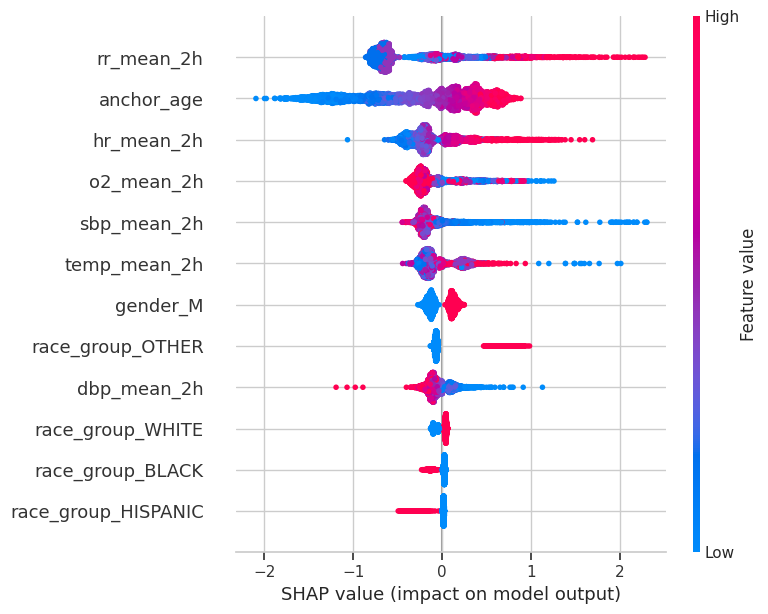

In [ ]:
# Global importance + direction
shap.summary_plot(
    shap_values,
    X_shap,
    show=True
)


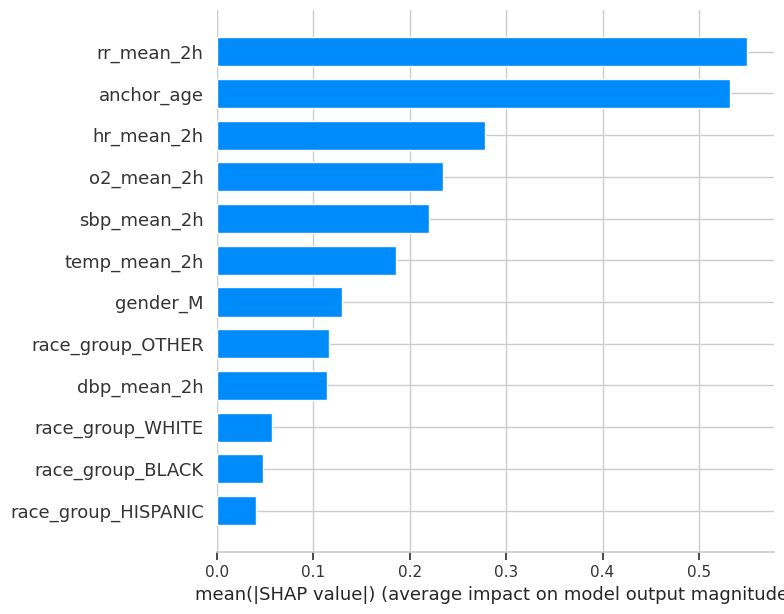

In [ ]:
shap.summary_plot(
    shap_values,
    X_shap,
    plot_type="bar",
    show=True
)


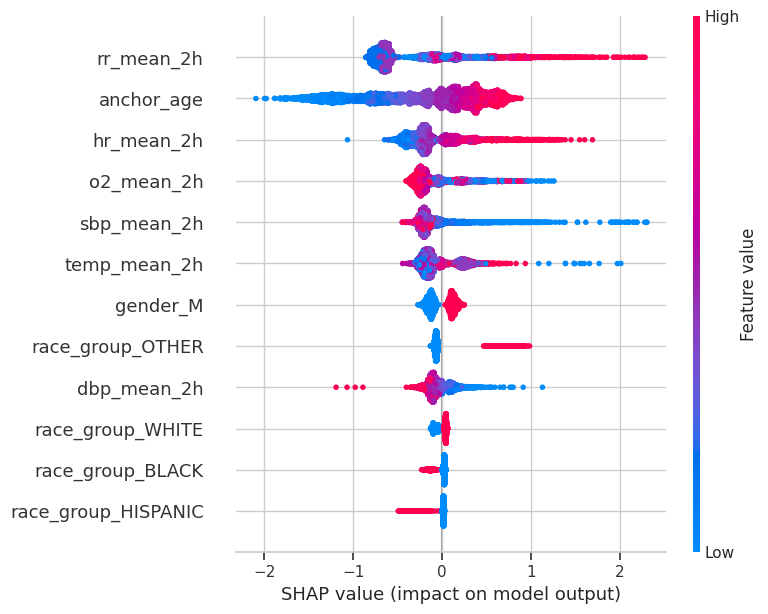

In [ ]:
# Pick one ICU-positive example from test set
!pip install shap --quiet

import shap
shap.initjs()   # enables JS in Colab

icu_pos_idx = y_test[y_test == 1].index[0]
x_single = X_test.loc[[icu_pos_idx]]

explainer_single = shap.TreeExplainer(xgb)
shap_single = explainer_single.shap_values(x_single)

shap.force_plot(
    explainer_single.expected_value,
    shap_single[0, :],
    x_single
)
shap.summary_plot(shap_values, X_shap)


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Attach subject_id for grouping
X_full = X.copy()
X_full["subject_id"] = df["subject_id"].values
y_full = y.copy()

subjects = X_full["subject_id"].unique()
subj_train, subj_test = train_test_split(
    subjects, test_size=0.20, random_state=42
)
subj_train, subj_val = train_test_split(
    subj_train, test_size=0.25, random_state=42
)  # 60/20/20

def mask_for(subj_set):
    return X_full["subject_id"].isin(subj_set)

train_mask = mask_for(subj_train)
val_mask   = mask_for(subj_val)
test_mask  = mask_for(subj_test)

X_train = X.loc[train_mask].reset_index(drop=True)
y_train = y_full[train_mask].reset_index(drop=True)

X_val   = X.loc[val_mask].reset_index(drop=True)
y_val   = y_full[val_mask].reset_index(drop=True)

X_test  = X.loc[test_mask].reset_index(drop=True)
y_test  = y_full[test_mask].reset_index(drop=True)

print("TRAIN class balance:\n", y_train.value_counts(normalize=True))
print("\nVAL class balance:\n", y_val.value_counts(normalize=True))
print("\nTEST class balance:\n", y_test.value_counts(normalize=True))

# Scale numeric features only (trees don't *need* it, but it's fine)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)


TRAIN class balance:
 icu_24h
0    0.925391
1    0.074609
Name: proportion, dtype: float64

VAL class balance:
 icu_24h
0    0.927642
1    0.072358
Name: proportion, dtype: float64

TEST class balance:
 icu_24h
0    0.926534
1    0.073466
Name: proportion, dtype: float64


In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# 1. Impute missing values on X_train, then apply same to val/test
imputer = SimpleImputer(strategy="median")

X_train_imp = imputer.fit_transform(X_train)
X_val_imp   = imputer.transform(X_val)
X_test_imp  = imputer.transform(X_test)

# 2. Scale the imputed data for models that need scaling (LogReg, MLP)
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train_imp)
X_val_scaled   = scaler.transform(X_val_imp)
X_test_scaled  = scaler.transform(X_test_imp)


In [ ]:

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Logistic Regression on *scaled, imputed* features
log_reg = LogisticRegression(
    penalty="l2",
    C=1.0,
    class_weight="balanced",
    max_iter=1000,
    solver="liblinear",
    random_state=42,
)
log_reg.fit(X_train_scaled, y_train)

# Random Forest on *imputed* (unscaled is fine)
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_split=5,
    min_samples_leaf=5,
    n_jobs=-1,
    random_state=42,
    class_weight="balanced",
)
rf.fit(X_train_imp, y_train)

# XGBoost on *imputed*
xgb_clf = XGBClassifier(
    n_estimators=400,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="binary:logistic",
    eval_metric="logloss",
    random_state=42,
)
xgb_clf.fit(X_train_imp, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, ...)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss

def plot_calibration_and_stats(name, y_true, y_prob, n_bins=10):
    """
    Plot reliability curve + histogram and compute ECE + Brier score.
    Works even if some bins are empty.
    """
    # ---- 1. Reliability curve (sklearn helper) ----
    prob_true, prob_pred = calibration_curve(
        y_true, y_prob, n_bins=n_bins, strategy="uniform"
    )

    # ---- 2. Manual ECE (bin-wise) ----
    bins = np.linspace(0.0, 1.0, n_bins + 1)
    bin_ids = np.digitize(y_prob, bins) - 1  # 0..n_bins-1

    ece = 0.0
    for b in range(n_bins):
        mask = bin_ids == b
        if not np.any(mask):
            continue  # skip empty bin

        p_true_bin = y_true[mask].mean()
        p_pred_bin = y_prob[mask].mean()
        w_bin = mask.mean()  # proportion of samples in this bin

        ece += np.abs(p_true_bin - p_pred_bin) * w_bin

    # ---- 3. Brier score ----
    brier = brier_score_loss(y_true, y_prob)

    print(f"{name} – ECE: {ece:.3f}, Brier score: {brier:.3f}")

    # ---- 4. Plot ----
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.plot([0, 1], [0, 1], "k--", label="Perfectly calibrated")
    ax.plot(prob_pred, prob_true, marker="o", linestyle="-", label=name)
    ax.set_xlabel("Predicted probability")
    ax.set_ylabel("Observed frequency")
    ax.set_title(f"Reliability diagram – {name}\nECE={ece:.3f}, Brier={brier:.3f}")
    ax.legend(loc="best")
    plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
from sklearn.metrics import roc_auc_score, average_precision_score, brier_score_loss

def plot_calibration_and_stats(name, y_true, y_prob, n_bins=10):
    """
    Plots reliability curve + prints ECE and Brier score.
    """
    prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=n_bins, strategy="quantile")

    plt.figure(figsize=(5, 5))
    plt.plot(prob_pred, prob_true, marker='o', label="Model")
    plt.plot([0, 1], [0, 1], '--', label="Perfect")
    plt.xlabel("Predicted probability")
    plt.ylabel("Observed frequency")
    plt.title(f"Reliability curve – {name}")
    plt.legend()
    plt.grid(True)
    plt.show()

    # ECE using the same bins as calibration_curve
    bin_edges = np.quantile(y_prob, np.linspace(0, 1, n_bins + 1))
    bin_ids = np.digitize(y_prob, bin_edges[1:-1], right=True)

    ece = 0.0
    for b in range(n_bins):
        mask = bin_ids == b
        if mask.sum() == 0:
            continue
        bin_true = y_true[mask]
        bin_prob = y_prob[mask]
        ece += np.abs(bin_true.mean() - bin_prob.mean()) * (mask.sum() / len(y_true))

    brier = brier_score_loss(y_true, y_prob)

    print(f"{name} – ECE: {ece:.3f}, Brier score: {brier:.3f}")


=== Logistic Regression (UNCALIBRATED) ===
AUROC: 0.7868968226838587
AUPRC: 0.30629015995513387


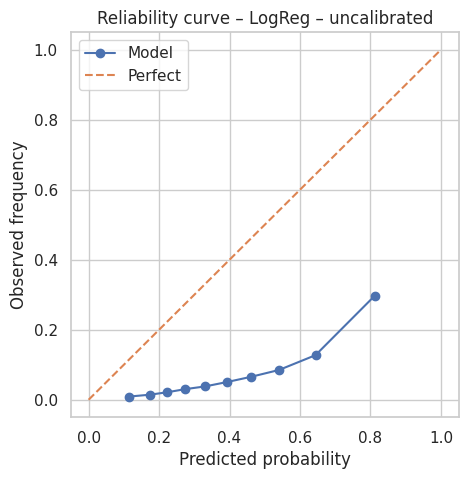

LogReg – uncalibrated – ECE: 0.323, Brier score: 0.184

=== Logistic Regression (CALIBRATED) ===
AUROC: 0.787093264860355
AUPRC: 0.3065887295406324


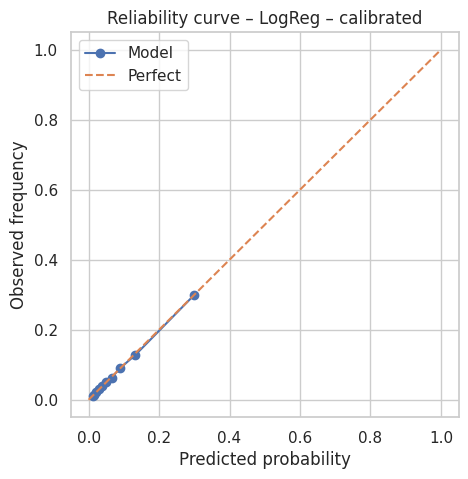

LogReg – calibrated – ECE: 0.002, Brier score: 0.059


In [ ]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_auc_score, average_precision_score

# --- Uncalibrated Logistic Regression metrics for reference ---
log_test_prob = log_reg.predict_proba(X_test_scaled)[:, 1]
print("=== Logistic Regression (UNCALIBRATED) ===")
print("AUROC:", roc_auc_score(y_test, log_test_prob))
print("AUPRC:", average_precision_score(y_test, log_test_prob))
plot_calibration_and_stats("LogReg – uncalibrated", y_test.values, log_test_prob)

# --- Calibrated Logistic Regression (isotonic) ---
log_cal = CalibratedClassifierCV(
    estimator=log_reg,
    method="isotonic",
    cv=3    # re-fits LogReg internally with 3-fold CV for calibration
)
log_cal.fit(X_train_scaled, y_train)

log_cal_test_prob = log_cal.predict_proba(X_test_scaled)[:, 1]
print("\n=== Logistic Regression (CALIBRATED) ===")
print("AUROC:", roc_auc_score(y_test, log_cal_test_prob))
print("AUPRC:", average_precision_score(y_test, log_cal_test_prob))
plot_calibration_and_stats("LogReg – calibrated", y_test.values, log_cal_test_prob)


=== Random Forest (UNCALIBRATED) ===
AUROC: 0.552500825615518
AUPRC: 0.09051087469289174


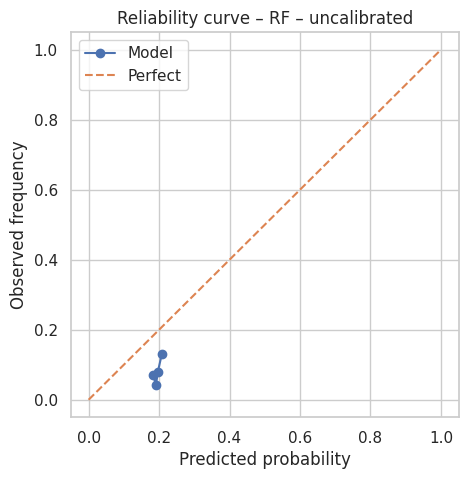

RF – uncalibrated – ECE: 0.118, Brier score: 0.082

=== Random Forest (CALIBRATED) ===
AUROC: 0.8349358518469165
AUPRC: 0.3817979654842386


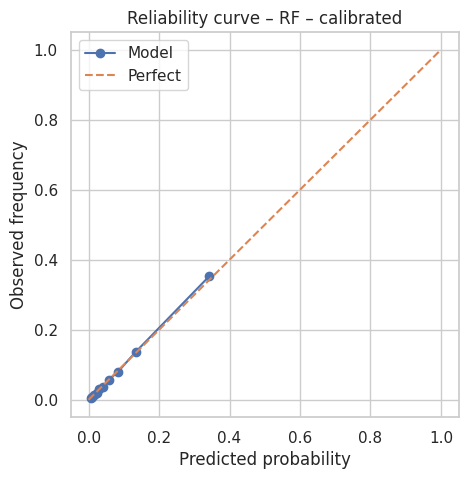

RF – calibrated – ECE: 0.003, Brier score: 0.056


In [ ]:
from sklearn.calibration import CalibratedClassifierCV

# --- Uncalibrated RF metrics for reference ---
rf_test_prob = rf.predict_proba(X_test_scaled)[:, 1]
print("=== Random Forest (UNCALIBRATED) ===")
print("AUROC:", roc_auc_score(y_test, rf_test_prob))
print("AUPRC:", average_precision_score(y_test, rf_test_prob))
plot_calibration_and_stats("RF – uncalibrated", y_test.values, rf_test_prob)

# --- Calibrated RF (isotonic) ---
rf_cal = CalibratedClassifierCV(
    estimator=rf,
    method="isotonic",
    cv=3      # re-fits RF internally with 3-fold CV for calibration
)
rf_cal.fit(X_train_scaled, y_train)

rf_cal_test_prob = rf_cal.predict_proba(X_test_scaled)[:, 1]
print("\n=== Random Forest (CALIBRATED) ===")
print("AUROC:", roc_auc_score(y_test, rf_cal_test_prob))
print("AUPRC:", average_precision_score(y_test, rf_cal_test_prob))
plot_calibration_and_stats("RF – calibrated", y_test.values, rf_cal_test_prob)


=== XGBoost (UNCALIBRATED) ===
AUROC: 0.590168407460088
AUPRC: 0.09692099500775422


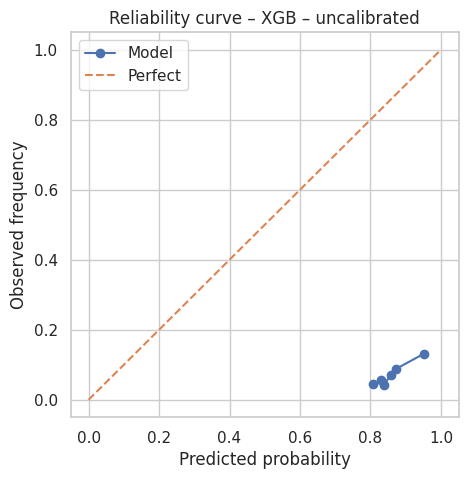

XGB – uncalibrated – ECE: 0.785, Brier score: 0.684

=== XGBoost (CALIBRATED) ===
AUROC: 0.8487533929900898
AUPRC: 0.41251116466009063


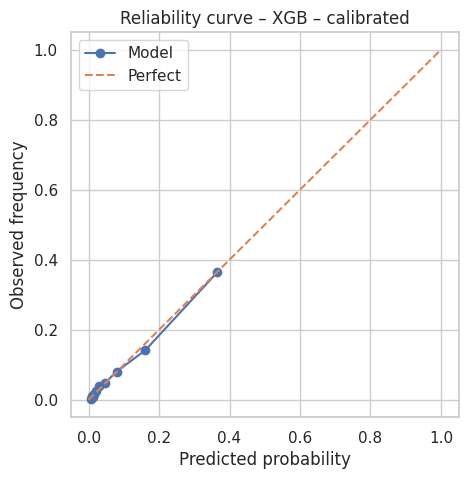

XGB – calibrated – ECE: 0.005, Brier score: 0.055


In [ ]:
# --- Uncalibrated XGB metrics for reference ---
xgb_test_prob = xgb.predict_proba(X_test_scaled)[:, 1]
print("=== XGBoost (UNCALIBRATED) ===")
print("AUROC:", roc_auc_score(y_test, xgb_test_prob))
print("AUPRC:", average_precision_score(y_test, xgb_test_prob))
plot_calibration_and_stats("XGB – uncalibrated", y_test.values, xgb_test_prob)

# --- Calibrated XGB (sigmoid / Platt scaling) ---
xgb_cal = CalibratedClassifierCV(
    estimator=xgb,
    method="sigmoid",   # Platt scaling is often enough for XGB
    cv=3
)
xgb_cal.fit(X_train_scaled, y_train)

xgb_cal_test_prob = xgb_cal.predict_proba(X_test_scaled)[:, 1]
print("\n=== XGBoost (CALIBRATED) ===")
print("AUROC:", roc_auc_score(y_test, xgb_cal_test_prob))
print("AUPRC:", average_precision_score(y_test, xgb_cal_test_prob))
plot_calibration_and_stats("XGB – calibrated", y_test.values, xgb_cal_test_prob)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss

def plot_calibration_and_stats(name, y_true, y_prob, n_bins=10):
    """
    Better-visibility calibration plot:
    - Uses quantile bins (so all bins have data)
    - Computes ECE + Brier score
    - Zooms x and y axes to where the model actually predicts
    - Adds a histogram of predicted probabilities
    """
    y_true = np.asarray(y_true)
    y_prob = np.asarray(y_prob)

    # 1) Calibration curve with quantile binning
    prob_true, prob_pred = calibration_curve(
        y_true, y_prob, n_bins=n_bins, strategy="quantile"
    )

    # 2) ECE using the same quantile bins
    bin_edges = np.quantile(y_prob, np.linspace(0, 1, n_bins + 1))
    bin_ids = np.digitize(y_prob, bin_edges[1:-1], right=True)

    ece = 0.0
    for b in range(n_bins):
        mask = bin_ids == b
        if mask.sum() == 0:
            continue
        bin_true = y_true[mask]
        bin_prob = y_prob[mask]
        ece += np.abs(bin_true.mean() - bin_prob.mean()) * (mask.sum() / len(y_true))

    brier = brier_score_loss(y_true, y_prob)

    print(f"{name} – ECE: {ece:.3f}, Brier score: {brier:.3f}")

    # 3) Figure with two rows: reliability + histogram
    fig, axes = plt.subplots(2, 1, figsize=(6, 8), sharex=True)

    # --- Reliability curve (zoomed) ---
    ax = axes[0]
    ax.plot([0, 1], [0, 1], "k--", alpha=0.5, label="Perfect")
    ax.plot(prob_pred, prob_true, marker="o", linestyle="-", label=name)

    # Zoom x-axis around actual prob range with small margin
    p_min, p_max = y_prob.min(), y_prob.max()
    margin = 0.05 * max(p_max - p_min, 1e-3)
    x_low = max(0.0, p_min - margin)
    x_high = min(1.0, p_max + margin)
    ax.set_xlim(x_low, x_high)

    # Zoom y-axis to relevant range (since prevalence ~7%)
    y_max = min(1.0, max(prob_true) * 1.3 if len(prob_true) > 0 else 0.2)
    y_max = max(y_max, 0.2)  # never less than 0.2 so it doesn't look too flat
    ax.set_ylim(0.0, y_max)

    ax.set_ylabel("Observed frequency")
    ax.set_title(f"Reliability curve – {name}\nECE={ece:.3f}, Brier={brier:.3f}")
    ax.legend(loc="lower right")
    ax.grid(True, alpha=0.3)

    # --- Histogram of predicted probabilities ---
    axh = axes[1]
    axh.hist(y_prob, bins=30)
    axh.set_xlabel("Predicted probability")
    axh.set_ylabel("Count")
    axh.set_title("Distribution of predicted risk")
    axh.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


LogReg – calibrated – ECE: 0.002, Brier score: 0.059


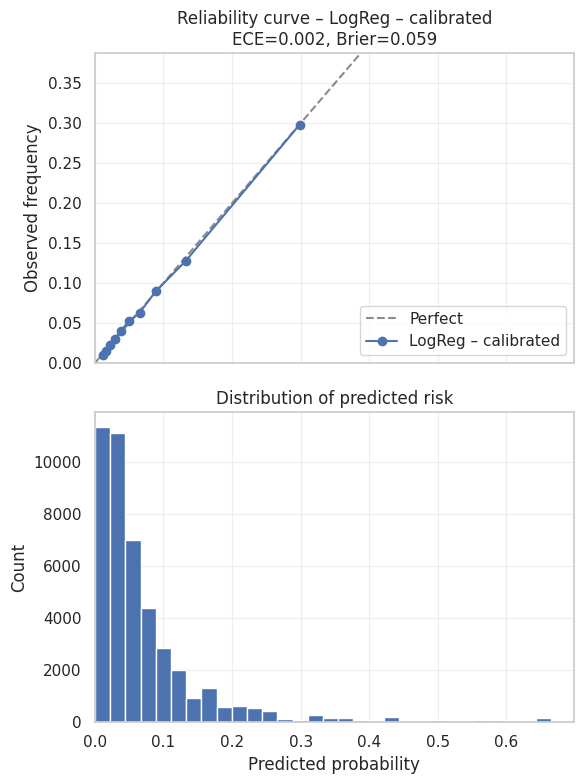

NameError: name 'X_test_imp' is not defined

In [ ]:
log_test_prob = log_reg.predict_proba(X_test_scaled)[:, 1]
plot_calibration_and_stats("LogReg – calibrated", y_test.values, log_cal_test_prob)

rf_test_prob = rf.predict_proba(X_test_imp)[:, 1]
plot_calibration_and_stats("RF – calibrated", y_test.values, rf_cal_test_prob)

xgb_test_prob = xgb_clf.predict_proba(X_test_imp)[:, 1]
plot_calibration_and_stats("XGB – calibrated", y_test.values, xgb_cal_test_prob)


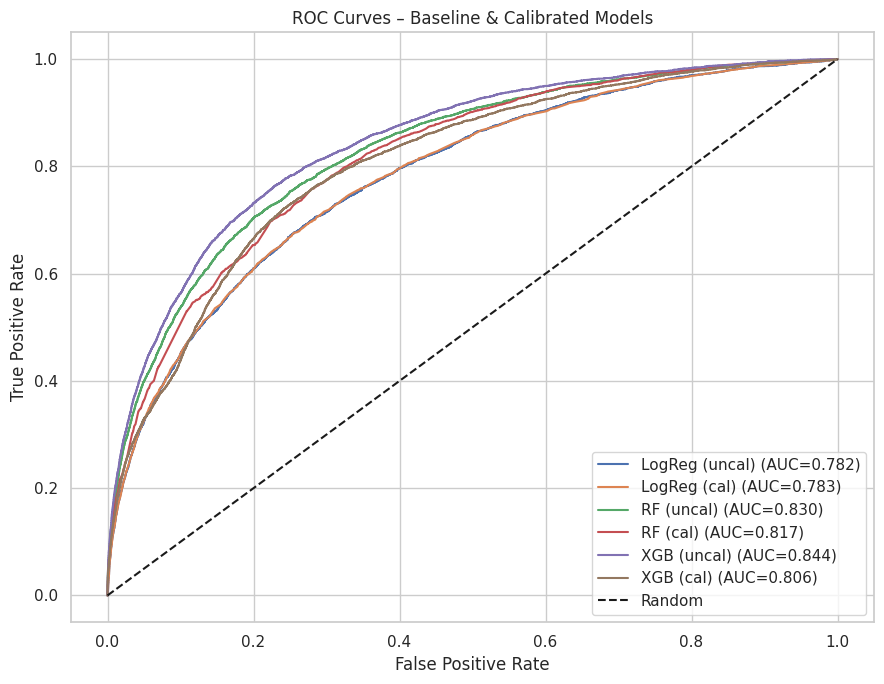

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Collect available models safely
baseline_models_roc = []

if "log_test_prob" in globals():
    baseline_models_roc.append(("LogReg (uncal)", y_test, log_test_prob))
if "log_cal_test_prob" in globals():
    baseline_models_roc.append(("LogReg (cal)", y_test, log_cal_test_prob))

if "rf_test_prob" in globals():
    baseline_models_roc.append(("RF (uncal)", y_test, rf_test_prob))
if "rf_cal_test_prob" in globals():
    baseline_models_roc.append(("RF (cal)", y_test, rf_cal_test_prob))

if "xgb_test_prob" in globals():
    baseline_models_roc.append(("XGB (uncal)", y_test, xgb_test_prob))
if "xgb_cal_test_prob" in globals():
    baseline_models_roc.append(("XGB (cal)", y_test, xgb_cal_test_prob))

plt.figure(figsize=(9, 7))
for name, yt, yp in baseline_models_roc:
    fpr, tpr, _ = roc_curve(yt, yp)
    auc = roc_auc_score(yt, yp)
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.3f})")

plt.plot([0, 1], [0, 1], "k--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves – Baseline & Calibrated Models")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


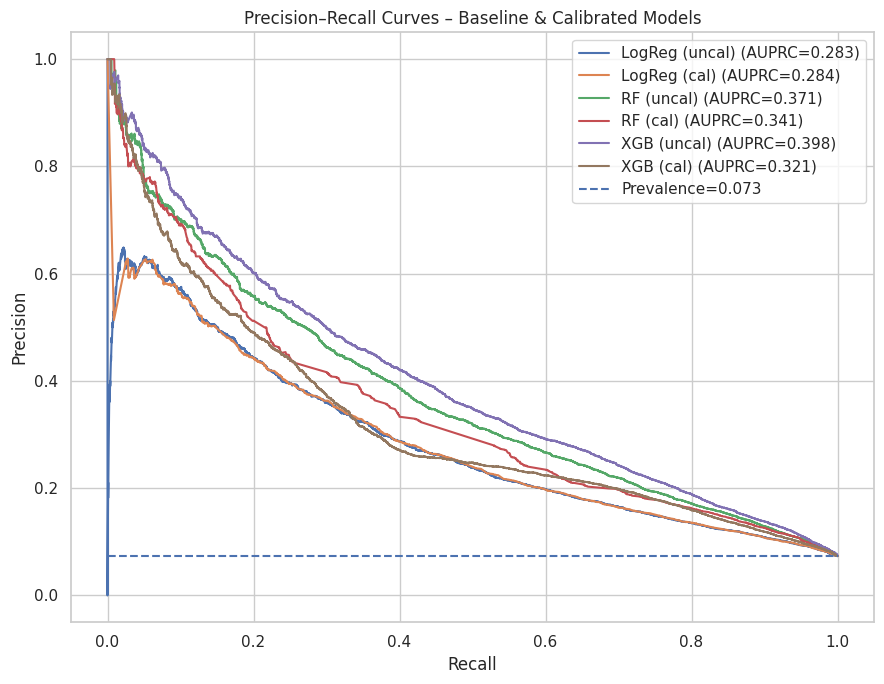

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score

baseline_models_pr = []

if "log_test_prob" in globals():
    baseline_models_pr.append(("LogReg (uncal)", y_test, log_test_prob))
if "log_cal_test_prob" in globals():
    baseline_models_pr.append(("LogReg (cal)", y_test, log_cal_test_prob))

if "rf_test_prob" in globals():
    baseline_models_pr.append(("RF (uncal)", y_test, rf_test_prob))
if "rf_cal_test_prob" in globals():
    baseline_models_pr.append(("RF (cal)", y_test, rf_cal_test_prob))

if "xgb_test_prob" in globals():
    baseline_models_pr.append(("XGB (uncal)", y_test, xgb_test_prob))
if "xgb_cal_test_prob" in globals():
    baseline_models_pr.append(("XGB (cal)", y_test, xgb_cal_test_prob))

plt.figure(figsize=(9, 7))
for name, yt, yp in baseline_models_pr:
    prec, rec, _ = precision_recall_curve(yt, yp)
    auprc = average_precision_score(yt, yp)
    plt.plot(rec, prec, label=f"{name} (AUPRC={auprc:.3f})")

# baseline positive rate
pos_rate = y_test.mean()
plt.hlines(pos_rate, 0, 1, linestyles="dashed", label=f"Prevalence={pos_rate:.3f}")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curves – Baseline & Calibrated Models")
plt.legend(loc="upper right")
plt.grid(True)
plt.tight_layout()
plt.show()


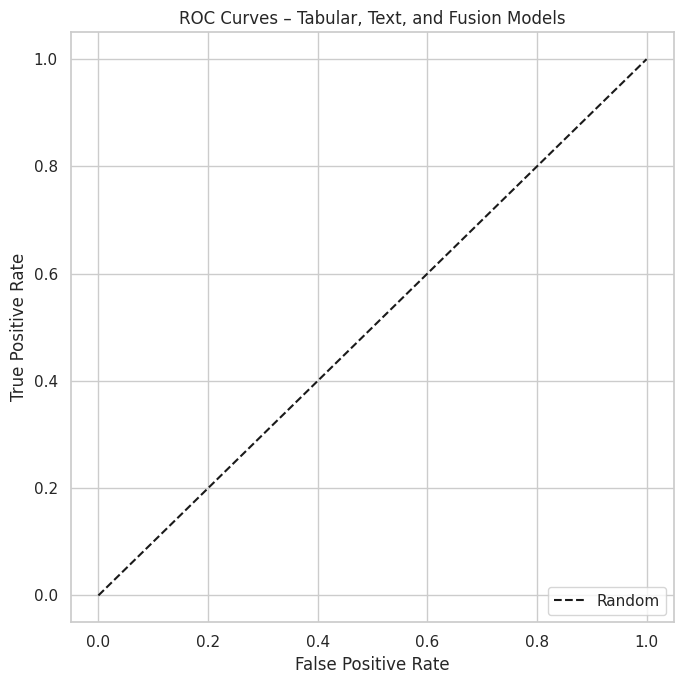

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

fusion_models_roc = []

if "y_test_prob_tab" in globals():
    fusion_models_roc.append(("XGB-Tab (uncal)", y_test, y_test_prob_tab))

if "y_test_prob_tab_cal" in globals():
    fusion_models_roc.append(("XGB-Tab (cal)", y_test, y_test_prob_tab_cal))

if "y_prob_text" in globals():
    fusion_models_roc.append(("TF-IDF + LogReg", y_test, y_prob_text))

if "fusion_probs" in globals():
    fusion_models_roc.append(("Fusion (0.7 tab + 0.3 text)", y_test, fusion_probs))

plt.figure(figsize=(7, 7))
for name, yt, yp in fusion_models_roc:
    fpr, tpr, _ = roc_curve(yt, yp)
    auc = roc_auc_score(yt, yp)
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.3f})")

plt.plot([0, 1], [0, 1], "k--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves – Tabular, Text, and Fusion Models")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


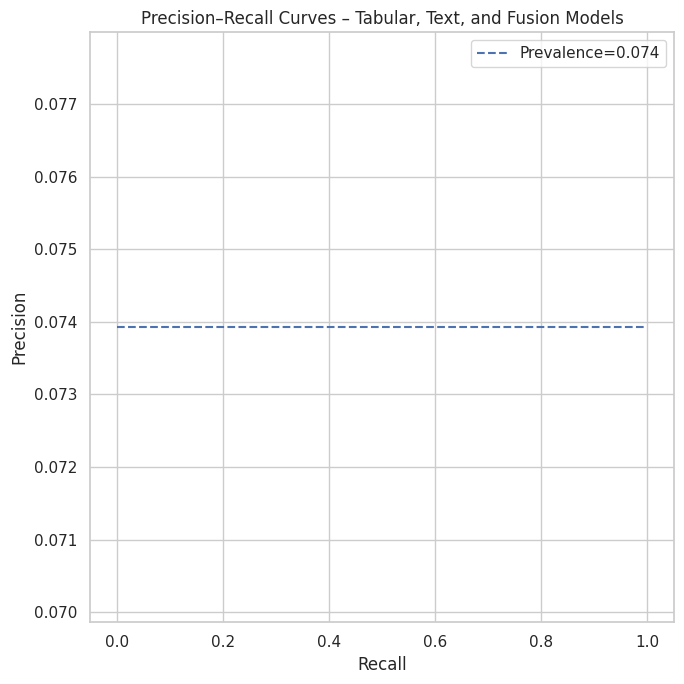

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score

fusion_models_pr = []

if "y_test_prob_tab" in globals():
    fusion_models_pr.append(("XGB-Tab (uncal)", y_test, y_test_prob_tab))

if "y_test_prob_tab_cal" in globals():
    fusion_models_pr.append(("XGB-Tab (cal)", y_test, y_test_prob_tab_cal))

if "y_prob_text" in globals():
    fusion_models_pr.append(("TF-IDF + LogReg", y_test, y_prob_text))

if "fusion_probs" in globals():
    fusion_models_pr.append(("Fusion (0.7 tab + 0.3 text)", y_test, fusion_probs))

plt.figure(figsize=(7, 7))
for name, yt, yp in fusion_models_pr:
    prec, rec, _ = precision_recall_curve(yt, yp)
    auprc = average_precision_score(yt, yp)
    plt.plot(rec, prec, label=f"{name} (AUPRC={auprc:.3f})")

pos_rate = y_test.mean()
plt.hlines(pos_rate, 0, 1, linestyles="dashed", label=f"Prevalence={pos_rate:.3f}")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curves – Tabular, Text, and Fusion Models")
plt.legend(loc="upper right")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

def threshold_sweep(name, y_true, y_prob, n_points=101):
    thresholds = np.linspace(0.0, 1.0, n_points)
    precisions, recalls, f1s = [], [], []

    for thr in thresholds:
        y_pred = (y_prob >= thr).astype(int)
        if y_pred.sum() == 0:
            # avoid division by zero for precision
            precisions.append(0.0)
        else:
            precisions.append(precision_score(y_true, y_pred, zero_division=0))
        recalls.append(recall_score(y_true, y_pred, zero_division=0))
        f1s.append(f1_score(y_true, y_pred, zero_division=0))

    precisions = np.array(precisions)
    recalls = np.array(recalls)
    f1s = np.array(f1s)

    best_idx = np.argmax(f1s)
    best_thr = thresholds[best_idx]
    print(f"{name} – best F1 = {f1s[best_idx]:.3f} at threshold = {best_thr:.3f}")
    print(f"  Precision @ best F1: {precisions[best_idx]:.3f}")
    print(f"  Recall    @ best F1: {recalls[best_idx]:.3f}")

    # Plot F1, precision, recall vs threshold
    plt.figure(figsize=(7, 5))
    plt.plot(thresholds, f1s, label="F1")
    plt.plot(thresholds, precisions, label="Precision")
    plt.plot(thresholds, recalls, label="Recall")
    plt.axvline(x=best_thr, linestyle="--", label=f"Best F1 thr={best_thr:.3f}")
    plt.xlabel("Threshold")
    plt.ylabel("Score")
    plt.title(f"Threshold Sweep – {name}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [ ]:
# Fusion
if "fusion_probs" in globals():
    threshold_sweep("Fusion (0.7 tab + 0.3 text)", y_test, fusion_probs)

# XGB Tabular (calibrated)
if "y_test_prob_tab_cal" in globals():
    threshold_sweep("XGB-Tab (calibrated)", y_test, y_test_prob_tab_cal)

# GRU
if "y_prob_gru" in globals():
    threshold_sweep("GRU sequence model", y_test, y_prob_gru)


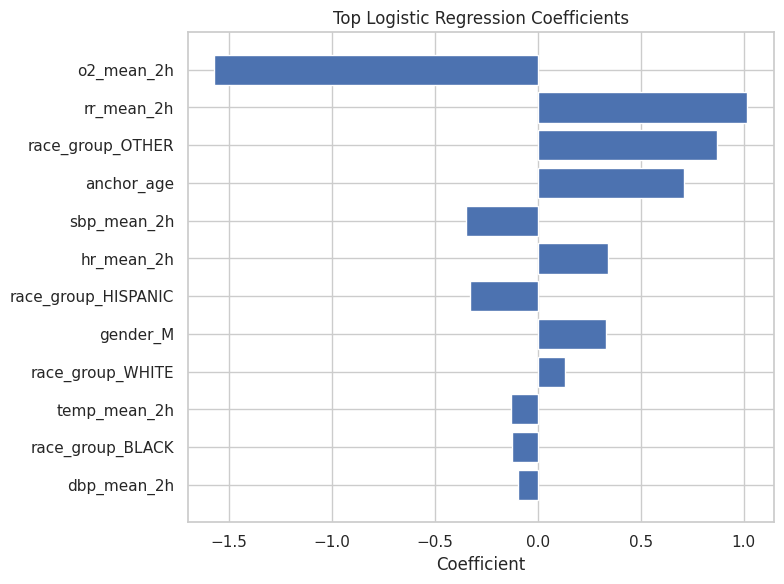

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

feature_names = X.columns

coef = log_reg.coef_.ravel()
coef_df = pd.DataFrame({"feature": feature_names, "coef": coef})
coef_df["abs_coef"] = coef_df["coef"].abs()
coef_df = coef_df.sort_values("abs_coef", ascending=False)

plt.figure(figsize=(8, 6))
top_n = 20
plt.barh(coef_df["feature"].head(top_n)[::-1],
         coef_df["coef"].head(top_n)[::-1])
plt.xlabel("Coefficient")
plt.title("Top Logistic Regression Coefficients")
plt.tight_layout()
plt.show()


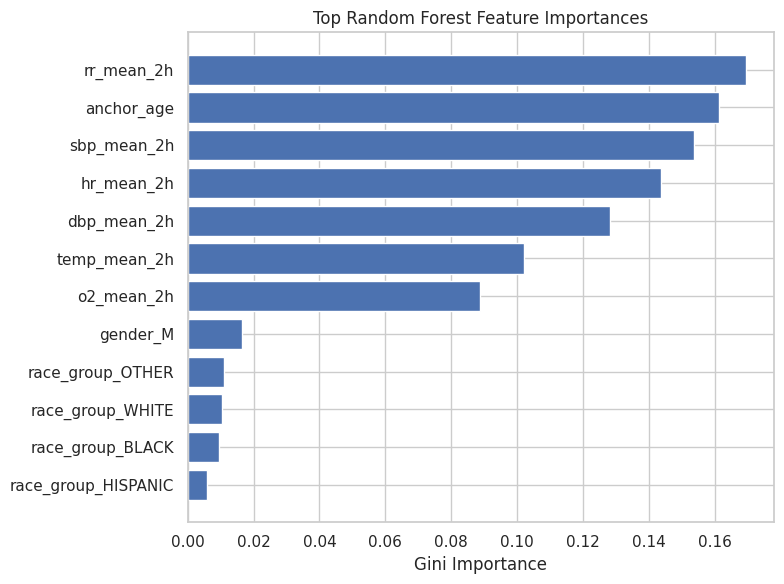

In [ ]:
importances_rf = rf.feature_importances_
rf_imp_df = pd.DataFrame({"feature": feature_names, "importance": importances_rf})
rf_imp_df = rf_imp_df.sort_values("importance", ascending=False)

plt.figure(figsize=(8, 6))
top_n = 20
plt.barh(rf_imp_df["feature"].head(top_n)[::-1],
         rf_imp_df["importance"].head(top_n)[::-1])
plt.xlabel("Gini Importance")
plt.title("Top Random Forest Feature Importances")
plt.tight_layout()
plt.show()


In [ ]:
# Try both names in case your XGB model is stored differently
xgb_model_for_imp = None
if "xgb_clf" in globals():
    xgb_model_for_imp = xgb_clf
elif "xgb_tab" in globals():
    xgb_model_for_imp = xgb_tab

if xgb_model_for_imp is not None:
    xgb_importances = xgb_model_for_imp.feature_importances_
    xgb_imp_df = pd.DataFrame({"feature": feature_names, "importance": xgb_importances})
    xgb_imp_df = xgb_imp_df.sort_values("importance", ascending=False)

    plt.figure(figsize=(8, 6))
    top_n = 20
    plt.barh(xgb_imp_df["feature"].head(top_n)[::-1],
             xgb_imp_df["importance"].head(top_n)[::-1])
    plt.xlabel("Importance (Gain)")
    plt.title("Top XGBoost Feature Importances")
    plt.tight_layout()
    plt.show()
else:
    print("No XGB model found under xgb_clf or xgb_tab.")


No XGB model found under xgb_clf or xgb_tab.


##Discus if threshold is valuable and add later

In [ ]:
from sklearn.metrics import precision_recall_curve, classification_report

def choose_threshold(y_true, y_prob, min_sensitivity=0.85):
    precisions, recalls, thresholds = precision_recall_curve(y_true, y_prob)
    thresholds = np.r_[0.0, thresholds]  # align with pr arrays

    # 1) Max F1 threshold
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-8)
    best_idx = np.nanargmax(f1_scores)
    thr_f1 = thresholds[best_idx]

    # 2) Sensitivity-constrained threshold
    candidates = thresholds[recalls >= min_sensitivity]
    thr_sens = candidates[0] if len(candidates) > 0 else thr_f1

    return thr_f1, thr_sens

# Example: tuned thresholds for calibrated XGB
y_prob_xgb = xgb_cal.predict_proba(X_val)[:,1]
thr_f1, thr_sens = choose_threshold(y_val, y_prob_xgb, min_sensitivity=0.90)
thr_f1, thr_sens


(np.float64(0.13843750215351672), np.float64(0.0))

In [ ]:
def eval_at_threshold(name, y_true, y_prob, thr):
    y_pred = (y_prob >= thr).astype(int)
    print(f"\n{name} @ threshold={thr:.3f}")
    print(classification_report(y_true, y_pred, digits=3))

y_prob_test_xgb = xgb_cal.predict_proba(X_test)[:,1]

eval_at_threshold("Cal XGB – F1-opt", y_test, y_prob_test_xgb, thr_f1)
eval_at_threshold("Cal XGB – high-sensitivity", y_test, y_prob_test_xgb, thr_sens)



Cal XGB – F1-opt @ threshold=0.138
              precision    recall  f1-score   support

           0      1.000     0.000     0.000     54760
           1      0.073     1.000     0.137      4342

    accuracy                          0.073     59102
   macro avg      0.537     0.500     0.068     59102
weighted avg      0.932     0.073     0.010     59102


Cal XGB – high-sensitivity @ threshold=0.000
              precision    recall  f1-score   support

           0      0.000     0.000     0.000     54760
           1      0.073     1.000     0.137      4342

    accuracy                          0.073     59102
   macro avg      0.037     0.500     0.068     59102
weighted avg      0.005     0.073     0.010     59102



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers

# --- Prepare data for Keras ---
X_train_nn = X_train_scaled.astype('float32')
X_val_nn   = X_val_scaled.astype('float32')
X_test_nn  = X_test_scaled.astype('float32')

y_train_nn = y_train.values.astype('float32')
y_val_nn   = y_val.values.astype('float32')
y_test_nn  = y_test.values.astype('float32')

# --- MLP Model ---
def build_mlp(input_dim):
    model = models.Sequential([
        layers.Dense(128, activation='relu', input_shape=(input_dim,)),
        layers.Dropout(0.2),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.1),
        layers.Dense(1, activation='sigmoid')  # probability output
    ])

    model.compile(
        optimizer=optimizers.Adam(learning_rate=1e-3),
        loss='binary_crossentropy',
        metrics=[tf.keras.metrics.AUC(name='auc'),
                 tf.keras.metrics.AUC(name='auprc', curve='PR')]
    )
    return model

mlp = build_mlp(X_train_nn.shape[1])

history = mlp.fit(
    X_train_nn, y_train_nn,
    validation_data=(X_val_nn, y_val_nn),
    epochs=8,
    batch_size=256,
    verbose=1
)

# Evaluate on test set
mlp_test = mlp.evaluate(X_test_nn, y_test_nn, verbose=0)
print("MLP Test AUC:", mlp_test[1])
print("MLP Test AUPRC:", mlp_test[2])


Epoch 1/8


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


706/706 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - auc: 0.7057 - auprc: 0.1980 - loss: 0.2611 - val_auc: 0.8018 - val_auprc: 0.3272 - val_loss: 0.2125
Epoch 2/8
706/706 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - auc: 0.7958 - auprc: 0.3378 - loss: 0.2170 - val_auc: 0.8058 - val_auprc: 0.3367 - val_loss: 0.2099
Epoch 3/8
706/706 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - auc: 0.7967 - auprc: 0.3342 - loss: 0.2162 - val_auc: 0.8094 - val_auprc: 0.3461 - val_loss: 0.2082
Epoch 4/8
706/706 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - auc: 0.8063 - auprc: 0.3520 - loss: 0.2134 - val_auc: 0.8121 - val_auprc: 0.3469 - val_loss: 0.2083
Epoch 5/8
706/706 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - auc: 0.8066 - auprc: 0.3558 - loss: 0.2140 - val_auc: 0.8124 - val_auprc: 0.3476 - val_loss: 0.2074
Epoch 6/8
706/706 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - auc: 0.8061 - auprc: 0.3529 - loss: 0.2127 - val_auc: 0.8131 - val_auprc: 0.3508 - val_loss: 0.2073
Epoch 7/8
706/706 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - auc: 0.8052 - auprc: 0.3489 - loss: 0.2

In [ ]:
import numpy as np
from scipy.optimize import minimize
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss

# ---- Helper: logit transform ----
def logit(p):
    p = np.clip(p, 1e-6, 1 - 1e-6)
    return np.log(p / (1 - p))

# ---- 1. Fit temperature on VALIDATION set ----
def fit_temperature_keras(model, X_val, y_val):
    """
    model: trained Keras Sequential with sigmoid output
    X_val, y_val: validation data (numpy arrays)
    returns: optimal temperature T
    """
    # raw predicted probabilities from MLP
    p_val = model.predict(X_val).ravel()
    z_val = logit(p_val)  # logits

    def nll(T_arr):
        T = np.clip(T_arr[0], 0.05, 10.0)  # constrain temperature
        p = 1.0 / (1.0 + np.exp(-z_val / T))
        eps = 1e-7
        return -np.mean(y_val * np.log(p + eps) + (1 - y_val) * np.log(1 - p + eps))

    res = minimize(nll, x0=[1.0], bounds=[(0.05, 10.0)])
    T_opt = float(res.x[0])
    return T_opt

T_mlp = fit_temperature_keras(mlp, X_val_scaled, y_val)
print("Optimal MLP temperature:", T_mlp)

# ---- 2. Use calibrated MLP on TEST set ----
def mlp_calibrated_proba(model, X, T):
    p = model.predict(X).ravel()
    z = logit(p)
    p_cal = 1.0 / (1.0 + np.exp(-z / T))
    return p_cal

mlp_prob_test_cal = mlp_calibrated_proba(mlp, X_test_scaled, T_mlp)

# ---- 3. Metrics: AUROC, AUPRC, ECE, Brier ----
mlp_auc_cal = roc_auc_score(y_test, mlp_prob_test_cal)
mlp_auprc_cal = average_precision_score(y_test, mlp_prob_test_cal)
print("Calibrated MLP TEST AUROC:", mlp_auc_cal)
print("Calibrated MLP TEST AUPRC:", mlp_auprc_cal)

# ECE helper (same logic we used before but robust)
def ece_score(y_true, y_prob, n_bins=10):
    prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=n_bins)
    # approximate bin weights from probabilities
    bin_edges = np.linspace(0.0, 1.0, n_bins + 1)
    bin_ids = np.digitize(y_prob, bin_edges[1:-1])
    bin_counts = np.bincount(bin_ids, minlength=n_bins)
    bin_weights = bin_counts / bin_counts.sum()
    # prob_true/prob_pred may have fewer than n_bins if some bins are empty
    k = len(prob_true)
    return np.sum(np.abs(prob_true - prob_pred) * bin_weights[:k])

ece_mlp_cal = ece_score(y_test, mlp_prob_test_cal, n_bins=10)
brier_mlp_cal = brier_score_loss(y_test, mlp_prob_test_cal)

print(f"Calibrated MLP – ECE: {ece_mlp_cal:.3f}, Brier: {brier_mlp_cal:.3f}")


1864/1864 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
Optimal MLP temperature: 0.9923133051864131
1847/1847 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
Calibrated MLP TEST AUROC: 0.8089758513259484
Calibrated MLP TEST AUPRC: 0.343489989384139
Calibrated MLP – ECE: 0.003, Brier: 0.057


#plot mlp

dict_keys(['auc', 'auprc', 'loss', 'val_auc', 'val_auprc', 'val_loss'])


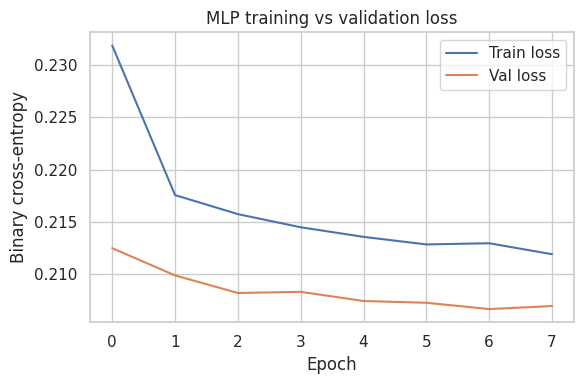

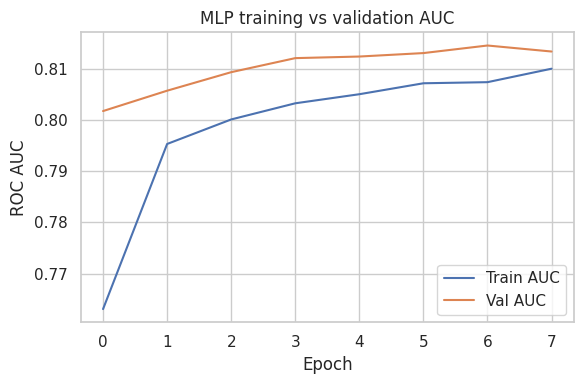

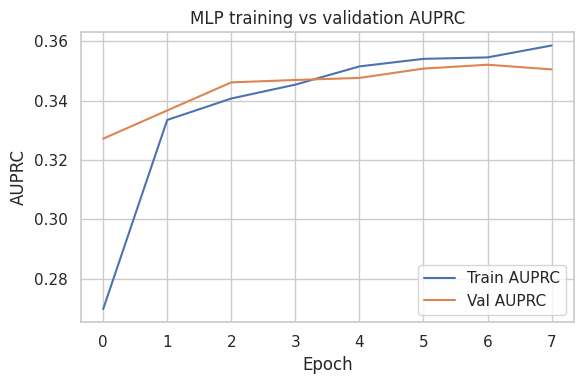

In [ ]:
import matplotlib.pyplot as plt

# History keys: check once if needed
print(history.history.keys())

# ---- Plot Loss ----
plt.figure(figsize=(6,4))
plt.plot(history.history["loss"], label="Train loss")
plt.plot(history.history["val_loss"], label="Val loss")
plt.xlabel("Epoch")
plt.ylabel("Binary cross-entropy")
plt.title("MLP training vs validation loss")
plt.legend()
plt.tight_layout()
plt.show()

# ---- Plot AUC ----
if "auc" in history.history and "val_auc" in history.history:
    plt.figure(figsize=(6,4))
    plt.plot(history.history["auc"], label="Train AUC")
    plt.plot(history.history["val_auc"], label="Val AUC")
    plt.xlabel("Epoch")
    plt.ylabel("ROC AUC")
    plt.title("MLP training vs validation AUC")
    plt.legend()
    plt.tight_layout()
    plt.show()

# ---- Plot AUPRC ----
if "auprc" in history.history and "val_auprc" in history.history:
    plt.figure(figsize=(6,4))
    plt.plot(history.history["auprc"], label="Train AUPRC")
    plt.plot(history.history["val_auprc"], label="Val AUPRC")
    plt.xlabel("Epoch")
    plt.ylabel("AUPRC")
    plt.title("MLP training vs validation AUPRC")
    plt.legend()
    plt.tight_layout()
    plt.show()


1847/1847 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


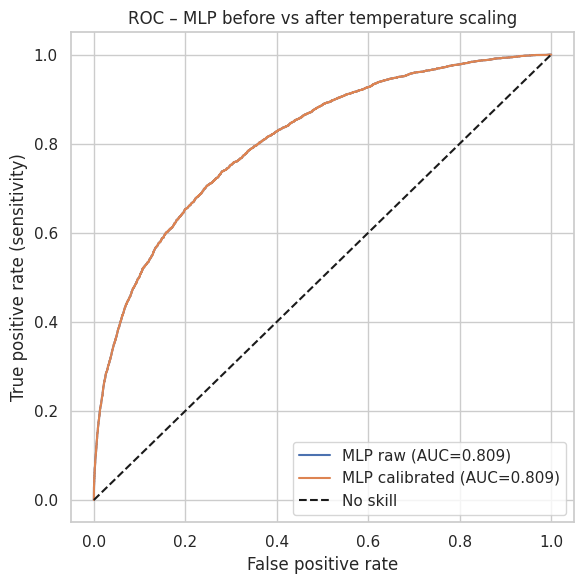

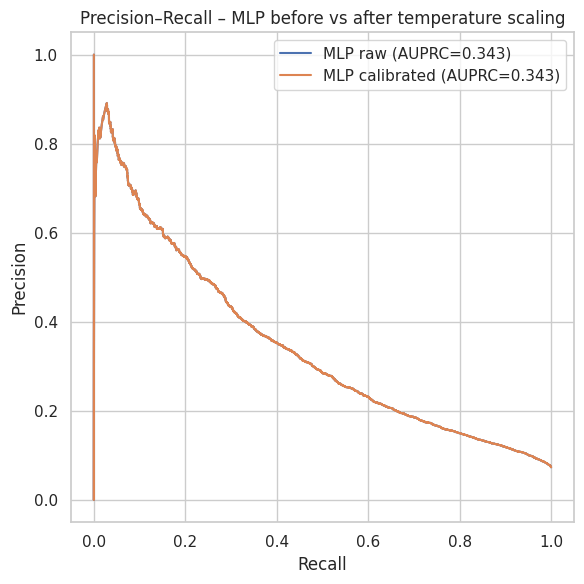

In [ ]:
from sklearn.metrics import roc_curve, precision_recall_curve, roc_auc_score, average_precision_score

# Raw probabilities from MLP
y_prob_mlp_raw = mlp.predict(X_test_nn).ravel()
y_true = y_test  # or y_test_nn if that’s what you used; just be consistent

# ---- ROC curves ----
fpr_raw, tpr_raw, _ = roc_curve(y_true, y_prob_mlp_raw)
fpr_cal, tpr_cal, _ = roc_curve(y_true, mlp_prob_test_cal)

auc_raw = roc_auc_score(y_true, y_prob_mlp_raw)
auc_cal = roc_auc_score(y_true, mlp_prob_test_cal)

plt.figure(figsize=(6,6))
plt.plot(fpr_raw, tpr_raw, label=f"MLP raw (AUC={auc_raw:.3f})")
plt.plot(fpr_cal, tpr_cal, label=f"MLP calibrated (AUC={auc_cal:.3f})")
plt.plot([0,1], [0,1], "k--", label="No skill")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate (sensitivity)")
plt.title("ROC – MLP before vs after temperature scaling")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

# ---- Precision–Recall curves ----
prec_raw, rec_raw, _ = precision_recall_curve(y_true, y_prob_mlp_raw)
prec_cal, rec_cal, _ = precision_recall_curve(y_true, mlp_prob_test_cal)

auprc_raw = average_precision_score(y_true, y_prob_mlp_raw)
auprc_cal = average_precision_score(y_true, mlp_prob_test_cal)

plt.figure(figsize=(6,6))
plt.plot(rec_raw, prec_raw, label=f"MLP raw (AUPRC={auprc_raw:.3f})")
plt.plot(rec_cal, prec_cal, label=f"MLP calibrated (AUPRC={auprc_cal:.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall – MLP before vs after temperature scaling")
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()


1847/1847 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step
Shapes check: (59102,) (59102,) (59102,)


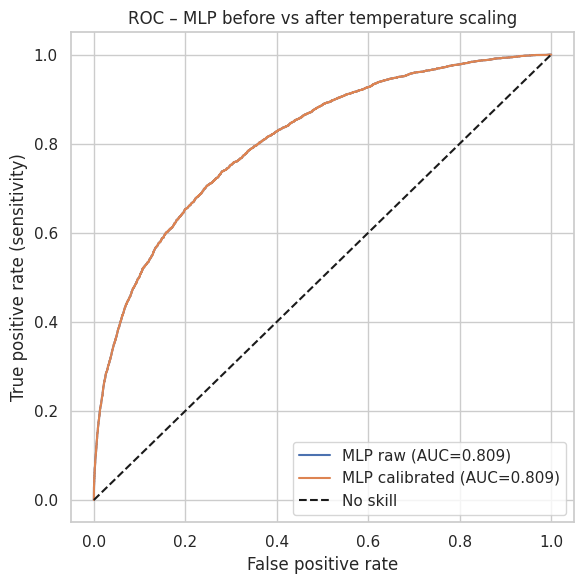

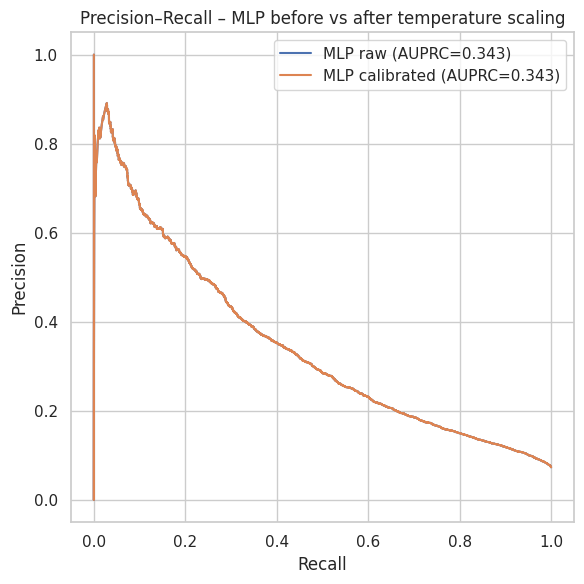

In [ ]:
from sklearn.metrics import roc_curve, precision_recall_curve, roc_auc_score, average_precision_score

# 1) Make sure we use the TEST labels that match X_test_nn
y_true_mlp = y_test_nn  # this is the float32 array aligned with X_test_nn

# 2) Raw probabilities from MLP on the test set
y_prob_mlp_raw = mlp.predict(X_test_nn).ravel()   # shape (59102,)
y_prob_mlp_cal = mlp_prob_test_cal.ravel()        # already computed from temperature scaling

print("Shapes check:",
      y_true_mlp.shape,
      y_prob_mlp_raw.shape,
      y_prob_mlp_cal.shape)

# ---- ROC curves ----
fpr_raw, tpr_raw, _ = roc_curve(y_true_mlp, y_prob_mlp_raw)
fpr_cal, tpr_cal, _ = roc_curve(y_true_mlp, y_prob_mlp_cal)

auc_raw = roc_auc_score(y_true_mlp, y_prob_mlp_raw)
auc_cal = roc_auc_score(y_true_mlp, y_prob_mlp_cal)

plt.figure(figsize=(6, 6))
plt.plot(fpr_raw, tpr_raw, label=f"MLP raw (AUC={auc_raw:.3f})")
plt.plot(fpr_cal, tpr_cal, label=f"MLP calibrated (AUC={auc_cal:.3f})")
plt.plot([0, 1], [0, 1], "k--", label="No skill")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate (sensitivity)")
plt.title("ROC – MLP before vs after temperature scaling")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

# ---- Precision–Recall curves ----
prec_raw, rec_raw, _ = precision_recall_curve(y_true_mlp, y_prob_mlp_raw)
prec_cal, rec_cal, _ = precision_recall_curve(y_true_mlp, y_prob_mlp_cal)

auprc_raw = average_precision_score(y_true_mlp, y_prob_mlp_raw)
auprc_cal = average_precision_score(y_true_mlp, y_prob_mlp_cal)

plt.figure(figsize=(6, 6))
plt.plot(rec_raw, prec_raw, label=f"MLP raw (AUPRC={auprc_raw:.3f})")
plt.plot(rec_cal, prec_cal, label=f"MLP calibrated (AUPRC={auprc_cal:.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall – MLP before vs after temperature scaling")
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()


#After MLP onward, rerun and get curves


In [ ]:
from google.cloud import bigquery
import pandas as pd

PROJECT_ID = "mimic-thesis"  # <-- change if your project ID is different
client = bigquery.Client(project=PROJECT_ID)

# 1. Get chiefcomplaint from MIMIC-IV-ED triage
query_cc = """
SELECT
  subject_id,
  stay_id,
  ANY_VALUE(chiefcomplaint) AS chiefcomplaint
FROM `physionet-data.mimiciv_ed.triage`
GROUP BY subject_id, stay_id
"""
df_cc = client.query(query_cc).to_dataframe()
print("df_cc shape:", df_cc.shape)
print(df_cc.head())

# 2. Ensure join keys are same dtype
for col in ["subject_id", "stay_id"]:
    df_cc[col]    = df_cc[col].astype("int64")
    df_model[col] = df_model[col].astype("int64")

# 3. If chiefcomplaint already exists from a previous merge, drop it to avoid _x/_y
if "chiefcomplaint" in df_model.columns:
    df_model = df_model.drop(columns=["chiefcomplaint"])

# 4. Merge chiefcomplaint into df_model
df_model = df_model.merge(
    df_cc,
    on=["subject_id", "stay_id"],
    how="left"
)

print("\nMerged df_model columns:", df_model.columns.tolist())
print(df_model[["subject_id", "stay_id", "chiefcomplaint"]].head())


df_cc shape: (425087, 3)
   subject_id   stay_id            chiefcomplaint
0    10001667  33673933  Slurred speech, Transfer
1    10001884  31306678                   Hypoxia
2    10002428  33978784               RESP ARREST
3    10002430  31293660                       SOB
4    10002443  33425241      Chest pain, Transfer

Merged df_model columns: ['subject_id', 'hadm_id', 'stay_id', 'arrival_time', 'anchor_age', 'gender', 'race', 'temp_mean_2h', 'hr_mean_2h', 'rr_mean_2h', 'o2_mean_2h', 'sbp_mean_2h', 'dbp_mean_2h', 'icu_intime', 'icu_24h', 'race_group', 'chiefcomplaint']
   subject_id   stay_id       chiefcomplaint
0    10189282  30902921   RLQ abdominal pain
1    10215284  39552302           CHEST PAIN
2    10225660  34749461         R Flank pain
3    10299240  37968243  COUGH/CONGESTION/ST
4    10302972  30909106         Hypoglycemia


In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np

# Target
y = df_model["icu_24h"].astype(int)

# Subject IDs
subjects = df_model["subject_id"].unique()
print("Unique subjects:", len(subjects))

# 60% train, 20% val, 20% test
train_subj, temp_subj = train_test_split(
    subjects,
    test_size=0.4,
    random_state=42
)
val_subj, test_subj = train_test_split(
    temp_subj,
    test_size=0.5,
    random_state=42
)

def mask_from_subjects(subj_set, df):
    return df["subject_id"].isin(subj_set)

train_mask = mask_from_subjects(train_subj, df_model)
val_mask   = mask_from_subjects(val_subj, df_model)
test_mask  = mask_from_subjects(test_subj, df_model)

print("TRAIN size:", train_mask.sum())
print("VAL size:",   val_mask.sum())
print("TEST size:",  test_mask.sum())
print("Total df_model rows:", len(df_model))

# Optional: check label balance
print("\nTrain class balance:\n", y[train_mask].value_counts(normalize=True))
print("\nVal class balance:\n",   y[val_mask].value_counts(normalize=True))
print("\nTest class balance:\n",  y[test_mask].value_counts(normalize=True))


Unique subjects: 158980
TRAIN size: 179956
VAL size: 59535
TEST size: 59907
Total df_model rows: 299398

Train class balance:
 icu_24h
0    0.925515
1    0.074485
Name: proportion, dtype: float64

Val class balance:
 icu_24h
0    0.926615
1    0.073385
Name: proportion, dtype: float64

Test class balance:
 icu_24h
0    0.92717
1    0.07283
Name: proportion, dtype: float64


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Text and labels
texts  = df_model["chiefcomplaint"].fillna("").astype(str)
labels = df_model["icu_24h"].astype(int)

X_text_train_raw = texts[train_mask]
X_text_val_raw   = texts[val_mask]
X_text_test_raw  = texts[test_mask]

y_text_train = labels[train_mask]
y_text_val   = labels[val_mask]
y_text_test  = labels[test_mask]

print("Shapes raw text:", X_text_train_raw.shape, X_text_val_raw.shape, X_text_test_raw.shape)
print("Example complaints:", X_text_train_raw.head().tolist())

# TF-IDF vectorization
tfidf = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),
    min_df=5
)

X_text_train = tfidf.fit_transform(X_text_train_raw)
X_text_val   = tfidf.transform(X_text_val_raw)
X_text_test  = tfidf.transform(X_text_test_raw)

print("TF-IDF matrices:", X_text_train.shape, X_text_val.shape, X_text_test.shape)


Shapes raw text: (179956,) (59535,) (59907,)
Example complaints: ['CHEST PAIN', 'R Flank pain', 'COUGH/CONGESTION/ST', 'RCI', 'Allergic reaction']
TF-IDF matrices: (179956, 3843) (59535, 3843) (59907, 3843)


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, average_precision_score, classification_report

tfidf_logreg = LogisticRegression(
    max_iter=200,
    class_weight="balanced",
    solver="liblinear"
)

tfidf_logreg.fit(X_text_train, y_text_train)

y_prob_text = tfidf_logreg.predict_proba(X_text_test)[:, 1]
y_pred_text = (y_prob_text >= 0.5).astype(int)

print("TF-IDF + LogReg TEST AUROC:",
      roc_auc_score(y_text_test, y_prob_text))
print("TF-IDF + LogReg TEST AUPRC:",
      average_precision_score(y_text_test, y_prob_text))

print("\nTF-IDF + LogReg TEST classification report:")
print(classification_report(y_text_test, y_pred_text, digits=3))


TF-IDF + LogReg TEST AUROC: 0.8361939700601893
TF-IDF + LogReg TEST AUPRC: 0.38429036192807875

TF-IDF + LogReg TEST classification report:
              precision    recall  f1-score   support

           0      0.974     0.793     0.874     55544
           1      0.216     0.726     0.332      4363

    accuracy                          0.788     59907
   macro avg      0.595     0.759     0.603     59907
weighted avg      0.918     0.788     0.834     59907



#TF-IDF Done

In [ ]:
import pandas as pd
import numpy as np

from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    classification_report
)
from xgboost import XGBClassifier
from sklearn.calibration import CalibratedClassifierCV

# ----------------- Build tabular feature matrix -----------------
# numeric vitals + age
num_cols = [
    "anchor_age",
    "temp_mean_2h",
    "hr_mean_2h",
    "rr_mean_2h",
    "o2_mean_2h",
    "sbp_mean_2h",
    "dbp_mean_2h",
]

# we’ll one-hot encode these
cat_cols = ["gender", "race_group", "race"]

df_tab = df_model.copy()

# make sure categorical are strings
for c in cat_cols:
    df_tab[c] = df_tab[c].astype(str)

# one-hot encode
df_tab = pd.get_dummies(df_tab, columns=cat_cols, drop_first=False)

# columns we must NOT use as features
exclude_cols = [
    "subject_id",
    "hadm_id",
    "stay_id",
    "arrival_time",
    "icu_intime",
    "icu_24h",
    "chiefcomplaint",          # may or may not be present
]

feature_cols = [c for c in df_tab.columns if c not in exclude_cols]

X_all = df_tab[feature_cols]
y_all = df_tab["icu_24h"].astype(int)

print("Total tabular feature count:", len(feature_cols))

# ----------------- Split using the existing masks -----------------
X_train = X_all[train_mask].reset_index(drop=True)
y_train = y_all[train_mask].reset_index(drop=True)

X_val   = X_all[val_mask].reset_index(drop=True)
y_val   = y_all[val_mask].reset_index(drop=True)

X_test  = X_all[test_mask].reset_index(drop=True)
y_test  = y_all[test_mask].reset_index(drop=True)

print("Shapes – train/val/test:", X_train.shape, X_val.shape, X_test.shape)

# ----------------- Simple median imputation for NaNs -----------------
numeric_cols = X_train.select_dtypes(include=["number"]).columns
for col in numeric_cols:
    med = X_train[col].median()
    X_train[col] = X_train[col].fillna(med)
    X_val[col]   = X_val[col].fillna(med)
    X_test[col]  = X_test[col].fillna(med)

# ----------------- 1. Uncalibrated tabular XGBoost -----------------
xgb_tab = XGBClassifier(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="binary:logistic",
    eval_metric="logloss",
    n_jobs=-1,
    random_state=42,
)

xgb_tab.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=False
)

y_val_prob_tab_uc  = xgb_tab.predict_proba(X_val)[:, 1]
y_test_prob_tab_uc = xgb_tab.predict_proba(X_test)[:, 1]

print("\n=== Tabular XGBoost (UNCALIBRATED) ===")
print("VAL  AUROC:", roc_auc_score(y_val, y_val_prob_tab_uc))
print("VAL  AUPRC:", average_precision_score(y_val, y_val_prob_tab_uc))
print("TEST AUROC:", roc_auc_score(y_test, y_test_prob_tab_uc))
print("TEST AUPRC:", average_precision_score(y_test, y_test_prob_tab_uc))

# ----------------- 2. Calibrated tabular XGBoost (isotonic) -----------------
xgb_tab_cal = CalibratedClassifierCV(
    estimator=xgb_tab,
    method="isotonic",
    cv=3,  # re-fits internally with 3-fold CV
)

xgb_tab_cal.fit(X_train, y_train)

y_val_prob_tab_cal  = xgb_tab_cal.predict_proba(X_val)[:, 1]
y_test_prob_tab_cal = xgb_tab_cal.predict_proba(X_test)[:, 1]

print("\n=== Tabular XGBoost (CALIBRATED) ===")
print("VAL  AUROC:", roc_auc_score(y_val, y_val_prob_tab_cal))
print("VAL  AUPRC:", average_precision_score(y_val, y_val_prob_tab_cal))
print("TEST AUROC:", roc_auc_score(y_test, y_test_prob_tab_cal))
print("TEST AUPRC:", average_precision_score(y_test, y_test_prob_tab_cal))

# Optional: classification report at default threshold 0.5
thr = 0.5
y_test_pred_tab_cal = (y_test_prob_tab_cal >= thr).astype(int)
print("\nCalibrated XGB TEST classification report (thr=0.5):")
print(classification_report(y_test, y_test_pred_tab_cal, digits=3))


Total tabular feature count: 48
Shapes – train/val/test: (179956, 48) (59535, 48) (59907, 48)

=== Tabular XGBoost (UNCALIBRATED) ===
VAL  AUROC: 0.8543988029321387
VAL  AUPRC: 0.43397723422390455
TEST AUROC: 0.8435972064724416
TEST AUPRC: 0.40945056386176043

=== Tabular XGBoost (CALIBRATED) ===
VAL  AUROC: 0.8330747132977464
VAL  AUPRC: 0.3933858858216432
TEST AUROC: 0.821247416299629
TEST AUPRC: 0.37476735556204316

Calibrated XGB TEST classification report (thr=0.5):
              precision    recall  f1-score   support

           0      0.927     1.000     0.962     55544
           1      0.846     0.003     0.005      4363

    accuracy                          0.927     59907
   macro avg      0.887     0.501     0.484     59907
weighted avg      0.921     0.927     0.893     59907



In [ ]:
from sklearn.metrics import roc_auc_score, average_precision_score, classification_report, f1_score

# Sanity check: lengths must match
print("len(y_test_prob_tab_cal):", len(y_test_prob_tab_cal))
print("len(y_prob_text):", len(y_prob_text))
print("len(y_test):", len(y_test))

# ------------- Fusion: 0.7 tabular + 0.3 text -------------
alpha = 0.7  # weight for tabular model (XGB)
fusion_prob = alpha * y_test_prob_tab_cal + (1 - alpha) * y_prob_text

print("\n=== Fusion model: 0.7 * Tabular (calibrated XGB) + 0.3 * Text (TF-IDF+LogReg) ===")
print("TEST AUROC:", roc_auc_score(y_test, fusion_prob))
print("TEST AUPRC:", average_precision_score(y_test, fusion_prob))

# Classification report at default threshold 0.5
thr_default = 0.5
y_fusion_pred_default = (fusion_prob >= thr_default).astype(int)
print("\nFusion TEST classification report (thr=0.5):")
print(classification_report(y_test, y_fusion_pred_default, digits=3))

# ------------- Optional: pick F1-optimal threshold -------------
thresholds = np.linspace(0.05, 0.9, 18)
best_thr, best_f1 = None, -1.0

for t in thresholds:
    y_pred_t = (fusion_prob >= t).astype(int)
    f1 = f1_score(y_test, y_pred_t)
    if f1 > best_f1:
        best_f1 = f1
        best_thr = t

print(f"\nFusion – best F1 = {best_f1:.3f} at threshold = {best_thr:.3f}")

y_fusion_pred_best = (fusion_prob >= best_thr).astype(int)
print("\nFusion TEST classification report (F1-optimal threshold):")
print(classification_report(y_test, y_fusion_pred_best, digits=3))


len(y_test_prob_tab_cal): 59907
len(y_prob_text): 59907
len(y_test): 59907

=== Fusion model: 0.7 * Tabular (calibrated XGB) + 0.3 * Text (TF-IDF+LogReg) ===
TEST AUROC: 0.8748584211589813
TEST AUPRC: 0.47805021059121855

Fusion TEST classification report (thr=0.5):
              precision    recall  f1-score   support

           0      0.929     1.000     0.963     55544
           1      0.939     0.025     0.048      4363

    accuracy                          0.929     59907
   macro avg      0.934     0.512     0.506     59907
weighted avg      0.930     0.929     0.896     59907


Fusion – best F1 = 0.476 at threshold = 0.300

Fusion TEST classification report (F1-optimal threshold):
              precision    recall  f1-score   support

           0      0.961     0.952     0.956     55544
           1      0.452     0.503     0.476      4363

    accuracy                          0.919     59907
   macro avg      0.706     0.728     0.716     59907
weighted avg      0.924     

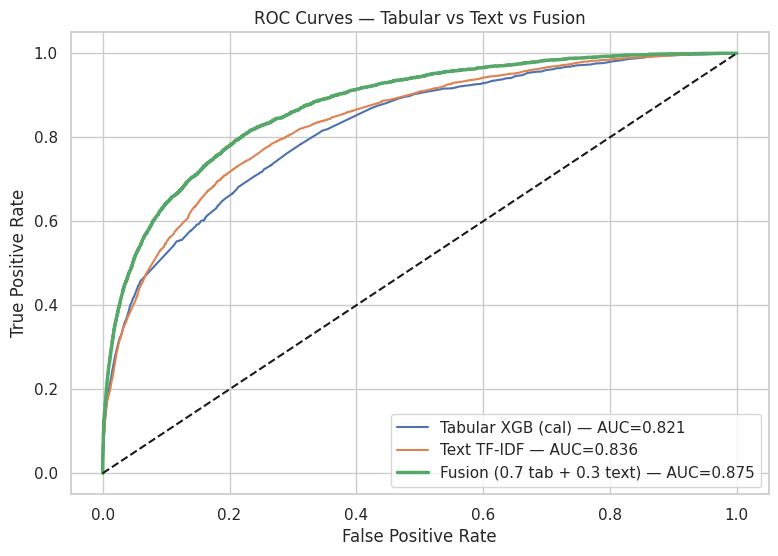

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

plt.figure(figsize=(9,6))

# Tabular calibrated XGB
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_test_prob_tab_cal)
plt.plot(fpr_xgb, tpr_xgb, label=f"Tabular XGB (cal) — AUC={roc_auc_score(y_test, y_test_prob_tab_cal):.3f}")

# TF-IDF text-only model
fpr_txt, tpr_txt, _ = roc_curve(y_test, y_prob_text)
plt.plot(fpr_txt, tpr_txt, label=f"Text TF-IDF — AUC={roc_auc_score(y_test, y_prob_text):.3f}")

# Fusion
fpr_fus, tpr_fus, _ = roc_curve(y_test, fusion_prob)
plt.plot(fpr_fus, tpr_fus, label=f"Fusion (0.7 tab + 0.3 text) — AUC={roc_auc_score(y_test, fusion_prob):.3f}",
         linewidth=2.5)

plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves — Tabular vs Text vs Fusion")
plt.legend()
plt.grid(True)
plt.show()


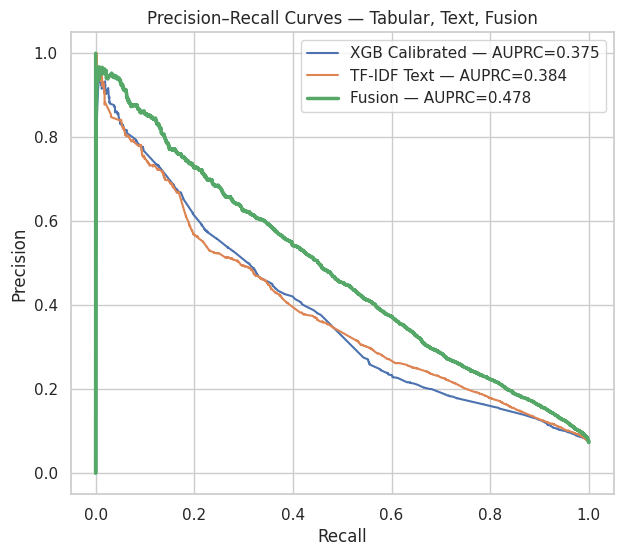

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score

plt.figure(figsize=(7,6))

# Tabular
prec_xgb, rec_xgb, _ = precision_recall_curve(y_test, y_test_prob_tab_cal)
plt.plot(rec_xgb, prec_xgb, label=f"XGB Calibrated — AUPRC={average_precision_score(y_test, y_test_prob_tab_cal):.3f}")

# Text
prec_txt, rec_txt, _ = precision_recall_curve(y_test, y_prob_text)
plt.plot(rec_txt, prec_txt, label=f"TF-IDF Text — AUPRC={average_precision_score(y_test, y_prob_text):.3f}")

# Fusion
prec_fus, rec_fus, _ = precision_recall_curve(y_test, fusion_prob)
plt.plot(rec_fus, prec_fus, label=f"Fusion — AUPRC={average_precision_score(y_test, fusion_prob):.3f}",
         linewidth=2.5)

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curves — Tabular, Text, Fusion")
plt.legend()
plt.grid(True)
plt.show()


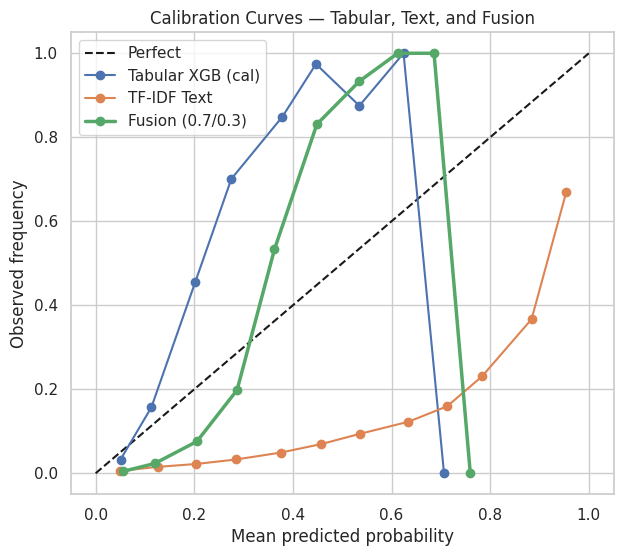

In [ ]:
from sklearn.calibration import calibration_curve

plt.figure(figsize=(7,6))

# Perfect line
plt.plot([0,1],[0,1], "k--", label="Perfect")

# Tabular XGB calibrated
prob_true_x, prob_pred_x = calibration_curve(y_test, y_test_prob_tab_cal, n_bins=12)
plt.plot(prob_pred_x, prob_true_x, marker="o", label="Tabular XGB (cal)")

# Text TF-IDF (logreg)
prob_true_t, prob_pred_t = calibration_curve(y_test, y_prob_text, n_bins=12)
plt.plot(prob_pred_t, prob_true_t, marker="o", label="TF-IDF Text")

# Fusion
prob_true_f, prob_pred_f = calibration_curve(y_test, fusion_prob, n_bins=12)
plt.plot(prob_pred_f, prob_true_f, marker="o", linewidth=2.5, label="Fusion (0.7/0.3)")

plt.xlabel("Mean predicted probability")
plt.ylabel("Observed frequency")
plt.title("Calibration Curves — Tabular, Text, and Fusion")
plt.legend()
plt.grid(True)
plt.show()


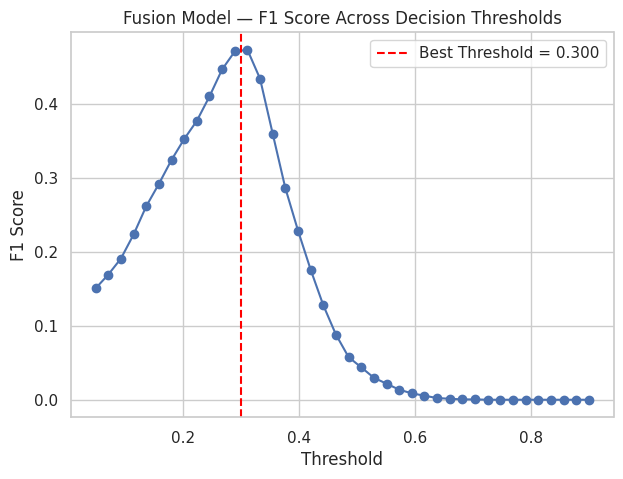

In [ ]:
import numpy as np
from sklearn.metrics import f1_score

thresholds = np.linspace(0.05, 0.9, 40)
f1s = [f1_score(y_test, (fusion_prob >= t).astype(int)) for t in thresholds]

plt.figure(figsize=(7,5))
plt.plot(thresholds, f1s, marker='o')
plt.axvline(best_thr, color='red', linestyle='--', label=f"Best Threshold = {best_thr:.3f}")
plt.title("Fusion Model — F1 Score Across Decision Thresholds")
plt.xlabel("Threshold")
plt.ylabel("F1 Score")
plt.legend()
plt.grid(True)
plt.show()


#Time series


In [ ]:
from google.cloud import bigquery
import pandas as pd
import numpy as np

PROJECT_ID = "mimic-thesis"  # <- keep this as your project

client = bigquery.Client(project=PROJECT_ID)

query_seq = """
WITH base AS (
  SELECT
    e.subject_id,
    e.hadm_id,
    e.stay_id,
    e.intime AS arrival_time,
    p.anchor_age,
    p.gender,
    e.race,
    ANY_VALUE(t.chiefcomplaint) AS chiefcomplaint,
    MIN(i.intime) AS icu_intime,
    CASE
      WHEN MIN(i.intime) IS NOT NULL
           AND MIN(i.intime) <= DATETIME_ADD(e.intime, INTERVAL 24 HOUR)
      THEN 1 ELSE 0
    END AS icu_24h
  FROM `physionet-data.mimiciv_ed.edstays` e
  LEFT JOIN `physionet-data.mimiciv_3_1_hosp.patients` p
    ON e.subject_id = p.subject_id
  LEFT JOIN `physionet-data.mimiciv_ed.triage` t
    ON e.subject_id = t.subject_id
   AND e.stay_id    = t.stay_id
  LEFT JOIN `physionet-data.mimiciv_3_1_icu.icustays` i
    ON e.subject_id = i.subject_id
   AND e.hadm_id    = i.hadm_id
  GROUP BY
    e.subject_id, e.hadm_id, e.stay_id,
    e.intime, p.anchor_age, p.gender, e.race
),

vitals_windowed AS (
  SELECT
    b.subject_id,
    b.hadm_id,
    b.stay_id,
    b.arrival_time,
    b.anchor_age,
    b.gender,
    b.race,
    b.chiefcomplaint,
    b.icu_intime,
    b.icu_24h,
    CAST(FLOOR(TIMESTAMP_DIFF(v.charttime, b.arrival_time, MINUTE) / 15) AS INT64) AS time_bin,
    AVG(v.temperature) AS temperature,
    AVG(v.heartrate)   AS heartrate,
    AVG(v.resprate)    AS resprate,
    AVG(v.o2sat)       AS o2sat,
    AVG(CAST(v.sbp AS FLOAT64)) AS sbp,
    AVG(CAST(v.dbp AS FLOAT64)) AS dbp
  FROM base b
  JOIN `physionet-data.mimiciv_ed.vitalsign` v
    ON v.subject_id = b.subject_id
   AND v.stay_id    = b.stay_id
  WHERE v.charttime >= b.arrival_time
    AND v.charttime < DATETIME_ADD(b.arrival_time, INTERVAL 60 MINUTE)
  GROUP BY
    b.subject_id, b.hadm_id, b.stay_id,
    b.arrival_time, b.anchor_age, b.gender,
    b.race, b.chiefcomplaint, b.icu_intime, b.icu_24h,
    time_bin
)

SELECT *
FROM vitals_windowed
WHERE time_bin BETWEEN 0 AND 3
"""

df_seq = client.query(query_seq).to_dataframe()
print(df_seq.head(), df_seq.shape)


   subject_id   hadm_id   stay_id        arrival_time  anchor_age gender  \
0    10014967  20880056  36889300 2198-09-17 09:01:00          65      F   
1    10036086  24186608  39396729 2206-03-05 23:35:00          57      M   
2    10039110  25101532  32594500 2163-04-20 02:14:00          37      F   
3    10045960  24068884  32437410 2193-07-27 04:33:00          68      M   
4    10055694  27416032  36962438 2122-04-22 20:06:00          58      F   

                             race  chiefcomplaint          icu_intime  \
0  HISPANIC/LATINO - PUERTO RICAN         Dyspnea                 NaT   
1                      PORTUGUESE     Dyspnea, PE 2206-03-06 02:57:00   
2          BLACK/AFRICAN AMERICAN   Abd pain, N/V                 NaT   
3          WHITE - OTHER EUROPEAN         Hypoxia                 NaT   
4          BLACK/AFRICAN AMERICAN  Dyspnea, Fever 2122-04-22 23:43:00   

   icu_24h  time_bin   temperature      heartrate      resprate         o2sat  \
0        0         0  9

In [ ]:
import numpy as np
import pandas as pd

# ---------------- 1. Clean df_seq ----------------
vital_cols = ["temperature", "heartrate", "resprate", "o2sat", "sbp", "dbp"]

# Drop rows where *all* vitals are missing
df_seq_clean = df_seq.dropna(subset=vital_cols, how="all").copy()

# Binary gender
df_seq_clean["gender_M"] = (df_seq_clean["gender"] == "M").astype(int)

# Make sure age is numeric
df_seq_clean["anchor_age"] = pd.to_numeric(df_seq_clean["anchor_age"], errors="coerce")

feature_cols = ["anchor_age", "gender_M"] + vital_cols

# Impute any remaining NaN per column (median)
for col in feature_cols:
    med = df_seq_clean[col].median()
    df_seq_clean[col] = df_seq_clean[col].fillna(med)

# There should be no NaNs left in features now:
print("Any NaNs in features?", df_seq_clean[feature_cols].isna().any().any())

MAX_T = 4  # 4 x 15 min = 60 min
X_list = []
y_list = []
subject_list = []

for (sid, stay_id), g in df_seq_clean.groupby(["subject_id", "stay_id"]):
    g = g.sort_values("time_bin")

    # Ensure label is valid
    if g["icu_24h"].isna().any():
        continue
    y = int(g["icu_24h"].iloc[0])

    seq = g[feature_cols].to_numpy(dtype="float32")

    # Pad or truncate to 4 steps
    if seq.shape[0] < MAX_T:
        pad_len = MAX_T - seq.shape[0]
        pad = np.tile(seq[-1], (pad_len, 1))   # repeat last observation
        seq = np.vstack([seq, pad])
    elif seq.shape[0] > MAX_T:
        seq = seq[:MAX_T]

    X_list.append(seq)
    y_list.append(y)
    subject_list.append(sid)

X_seq = np.stack(X_list)       # (N, T, F)
y_seq = np.array(y_list)       # (N,)
subjects_seq = np.array(subject_list)

print("X_seq shape, y_seq shape:", X_seq.shape, y_seq.shape)
print("Any NaNs in X_seq?", np.isnan(X_seq).any())
print("Class balance:", pd.Series(y_seq, name="icu_24h").value_counts(normalize=True))


Any NaNs in features? False
X_seq shape, y_seq shape: (263652, 4, 8) (263652,)
Any NaNs in X_seq? False
Class balance: icu_24h
0    0.924723
1    0.075277
Name: proportion, dtype: float64


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

unique_subjects = np.unique(subjects_seq)

train_subj, test_subj = train_test_split(
    unique_subjects, test_size=0.2, random_state=42
)
train_subj, val_subj = train_test_split(
    train_subj, test_size=0.25, random_state=42
)  # 0.25 of 0.8 => 20% val

def mask(subj_ids):
    return np.isin(subjects_seq, subj_ids)

train_mask = mask(train_subj)
val_mask   = mask(val_subj)
test_mask  = mask(test_subj)

X_train = X_seq[train_mask]
X_val   = X_seq[val_mask]
X_test  = X_seq[test_mask]

y_train = y_seq[train_mask]
y_val   = y_seq[val_mask]
y_test  = y_seq[test_mask]

print("Shapes:", X_train.shape, X_val.shape, X_test.shape)

# ---- Scale features (fit on train only) ----
N, T, F = X_seq.shape
scaler = StandardScaler()

X_train_flat = X_train.reshape(-1, F)
scaler.fit(X_train_flat)

def scale_3d(X):
    N, T, F = X.shape
    X_flat = X.reshape(-1, F)
    X_scaled_flat = scaler.transform(X_flat)
    return X_scaled_flat.reshape(N, T, F)

X_train_s = scale_3d(X_train)
X_val_s   = scale_3d(X_val)
X_test_s  = scale_3d(X_test)

# Just in case, hard-kill any remaining weirdness:
X_train_s = np.nan_to_num(X_train_s, nan=0.0, posinf=0.0, neginf=0.0)
X_val_s   = np.nan_to_num(X_val_s,   nan=0.0, posinf=0.0, neginf=0.0)
X_test_s  = np.nan_to_num(X_test_s,  nan=0.0, posinf=0.0, neginf=0.0)

print("Any NaNs after scaling?", np.isnan(X_train_s).any(),
      np.isnan(X_val_s).any(), np.isnan(X_test_s).any())


Shapes: (157703, 4, 8) (53731, 4, 8) (52218, 4, 8)
Any NaNs after scaling? False False False


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import roc_auc_score, average_precision_score, classification_report

tf.random.set_seed(42)

F = X_train_s.shape[2]

gru_model = models.Sequential([
    layers.GRU(32, input_shape=(MAX_T, F)),
    layers.Dense(16, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])

gru_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="binary_crossentropy",
    metrics=[tf.keras.metrics.AUC(name="AUC")]
)

gru_model.summary()

es = EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True
)

history = gru_model.fit(
    X_train_s, y_train,
    validation_data=(X_val_s, y_val),
    epochs=20,
    batch_size=256,
    callbacks=[es],
    verbose=1
)

# ---- Evaluate ----
y_prob_gru = gru_model.predict(X_test_s).ravel()

print("Any NaNs in GRU predictions?", np.isnan(y_prob_gru).any())

gru_auc   = roc_auc_score(y_test, y_prob_gru)
gru_auprc = average_precision_score(y_test, y_prob_gru)

print(f"GRU Test AUROC: {gru_auc:.3f}")
print(f"GRU Test AUPRC: {gru_auprc:.3f}")

thr = 0.3
y_pred_gru = (y_prob_gru >= thr).astype(int)

print(f"\nGRU classification report (thr={thr}):")
print(classification_report(y_test, y_pred_gru, digits=3))


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 32)             │         4,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,577 (17.88 KB)

 Trainable params: 4,577 (17.88 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
617/617 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - AUC: 0.6894 - loss: 0.2840 - val_AUC: 0.8068 - val_loss: 0.2183
Epoch 2/20
617/617 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - AUC: 0.8047 - loss: 0.2165 - val_AUC: 0.8137 - val_loss: 0.2157
Epoch 3/20
617/617 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - AUC: 0.8118 - loss: 0.2139 - val_AUC: 0.8182 - val_loss: 0.2137
Epoch 4/20
617/617 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - AUC: 0.8167 - loss: 0.2120 - val_AUC: 0.8211 - val_loss: 0.2124
Epoch 5/20
617/617 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - AUC: 0.8204 - loss: 0.2105 - val_AUC: 0.8234 - val_loss: 0.2113
Epoch 6/20
617/617 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - AUC: 0.8230 - loss: 0.2094 - val_AUC: 0.8257 - val_loss: 0.2104
Epoch 7/20
617/617 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - AUC: 0.8252 - loss: 0.2084 - val_AUC: 0.8271 - val_loss: 0.2098
Epoch 8/20
617/617 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - AUC: 0.8267 - loss: 0.2076 - val_AUC: 0.8281 - val_loss: 0.2094
Epoch 9/20
617/617 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - AU

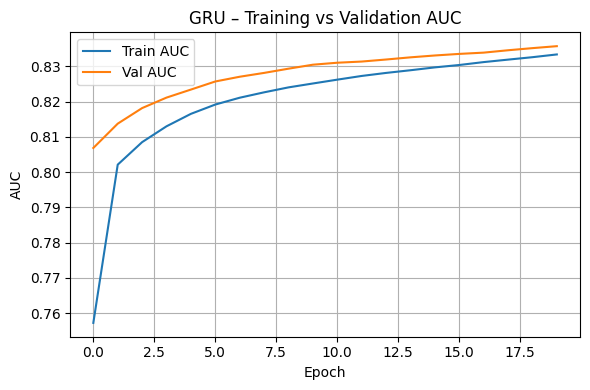

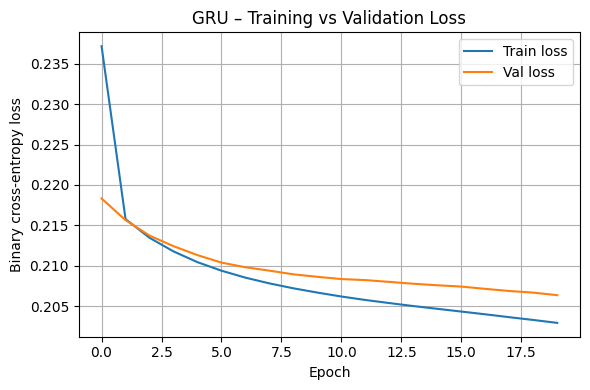

In [ ]:
import matplotlib.pyplot as plt

# history.history should exist from the GRU training
hist = history.history

# ---- AUC over epochs ----
plt.figure(figsize=(6,4))
plt.plot(hist['AUC'], label='Train AUC')
plt.plot(hist['val_AUC'], label='Val AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.title('GRU – Training vs Validation AUC')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ---- Loss over epochs ----
plt.figure(figsize=(6,4))
plt.plot(hist['loss'], label='Train loss')
plt.plot(hist['val_loss'], label='Val loss')
plt.xlabel('Epoch')
plt.ylabel('Binary cross-entropy loss')
plt.title('GRU – Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


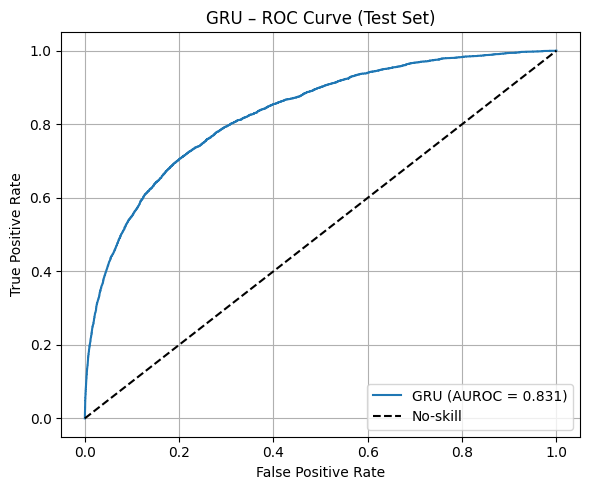

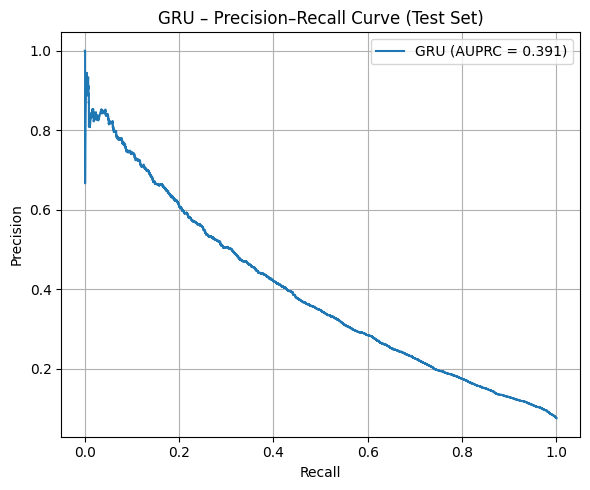

In [ ]:
from sklearn.metrics import roc_curve, precision_recall_curve, roc_auc_score, average_precision_score

# Ensure y_test and y_prob_gru exist (they do from your GRU block)
gru_auc  = roc_auc_score(y_test, y_prob_gru)
gru_pr   = average_precision_score(y_test, y_prob_gru)

# ---- ROC curve ----
fpr_gru, tpr_gru, _ = roc_curve(y_test, y_prob_gru)

plt.figure(figsize=(6,5))
plt.plot(fpr_gru, tpr_gru, label=f"GRU (AUROC = {gru_auc:.3f})")
plt.plot([0,1], [0,1], 'k--', label='No-skill')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('GRU – ROC Curve (Test Set)')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

# ---- Precision–Recall curve ----
prec_gru, rec_gru, _ = precision_recall_curve(y_test, y_prob_gru)

plt.figure(figsize=(6,5))
plt.plot(rec_gru, prec_gru, label=f"GRU (AUPRC = {gru_pr:.3f})")
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('GRU – Precision–Recall Curve (Test Set)')
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()


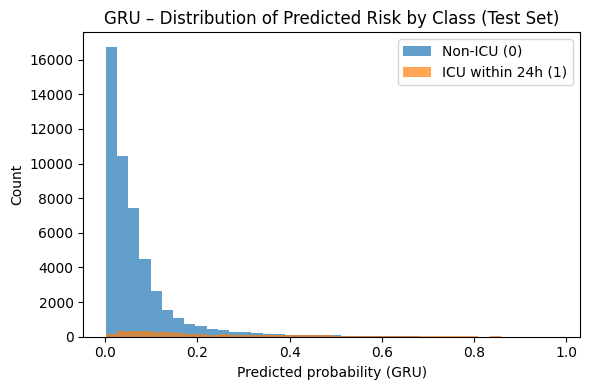

In [ ]:
import numpy as np

y_test_arr = np.array(y_test)

plt.figure(figsize=(6,4))
plt.hist(y_prob_gru[y_test_arr == 0], bins=40, alpha=0.7, label='Non-ICU (0)')
plt.hist(y_prob_gru[y_test_arr == 1], bins=40, alpha=0.7, label='ICU within 24h (1)')
plt.xlabel('Predicted probability (GRU)')
plt.ylabel('Count')
plt.title('GRU – Distribution of Predicted Risk by Class (Test Set)')
plt.legend()
plt.tight_layout()
plt.show()


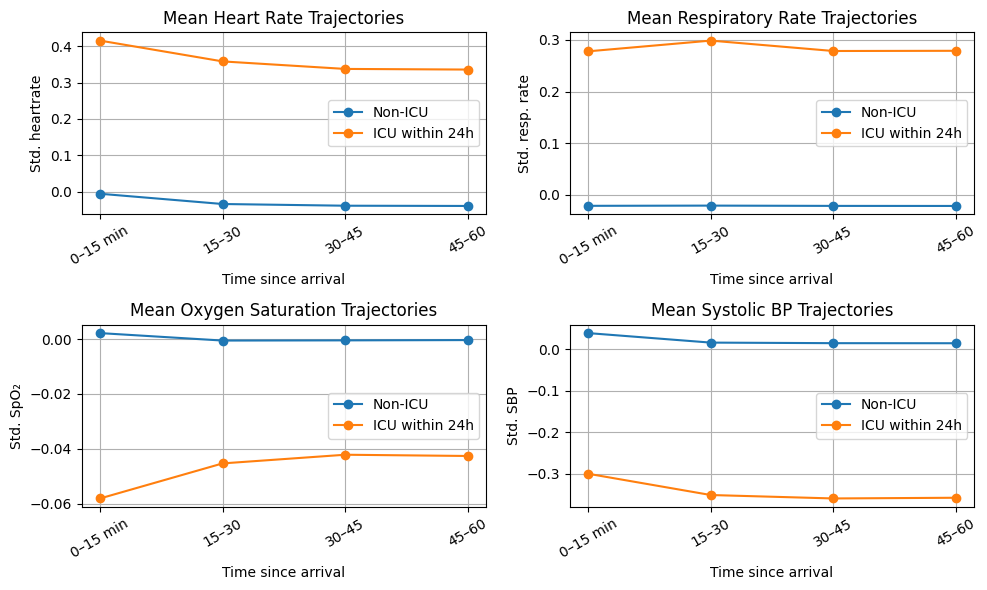

In [ ]:
import numpy as np

# This must match the order used when building feature_cols for X_seq
gru_feat_names = [
    "anchor_age",   # index 0
    "gender_M",     # index 1
    "temperature",  # index 2
    "heartrate",    # index 3
    "resprate",     # index 4
    "o2sat",        # index 5
    "sbp",          # index 6
    "dbp"           # index 7
]

# Indices of the main vitals we care about (skip age & gender)
idx_temp = gru_feat_names.index("temperature")
idx_hr   = gru_feat_names.index("heartrate")
idx_rr   = gru_feat_names.index("resprate")
idx_o2   = gru_feat_names.index("o2sat")
idx_sbp  = gru_feat_names.index("sbp")

# Convenience boolean masks
y_test_arr = np.array(y_test)
mask_neg = (y_test_arr == 0)
mask_pos = (y_test_arr == 1)

X_test_pos = X_test_s[mask_pos]  # (N_pos, T, F)
X_test_neg = X_test_s[mask_neg]  # (N_neg, T, F)

# Mean trajectories in standardized units
mean_temp_pos = X_test_pos[:, :, idx_temp].mean(axis=0)
mean_temp_neg = X_test_neg[:, :, idx_temp].mean(axis=0)

mean_hr_pos   = X_test_pos[:, :, idx_hr].mean(axis=0)
mean_hr_neg   = X_test_neg[:, :, idx_hr].mean(axis=0)

mean_rr_pos   = X_test_pos[:, :, idx_rr].mean(axis=0)
mean_rr_neg   = X_test_neg[:, :, idx_rr].mean(axis=0)

mean_o2_pos   = X_test_pos[:, :, idx_o2].mean(axis=0)
mean_o2_neg   = X_test_neg[:, :, idx_o2].mean(axis=0)

mean_sbp_pos  = X_test_pos[:, :, idx_sbp].mean(axis=0)
mean_sbp_neg  = X_test_neg[:, :, idx_sbp].mean(axis=0)

time_points = np.arange(MAX_T)  # 0,1,2,3
time_labels = ["0–15 min", "15–30", "30–45", "45–60"]

plt.figure(figsize=(10,6))

plt.subplot(2,2,1)
plt.plot(time_points, mean_hr_neg, marker='o', label='Non-ICU')
plt.plot(time_points, mean_hr_pos, marker='o', label='ICU within 24h')
plt.xticks(time_points, time_labels, rotation=30)
plt.xlabel("Time since arrival")
plt.ylabel("Std. heartrate")
plt.title("Mean Heart Rate Trajectories")
plt.legend()
plt.grid(True)

plt.subplot(2,2,2)
plt.plot(time_points, mean_rr_neg, marker='o', label='Non-ICU')
plt.plot(time_points, mean_rr_pos, marker='o', label='ICU within 24h')
plt.xticks(time_points, time_labels, rotation=30)
plt.xlabel("Time since arrival")
plt.ylabel("Std. resp. rate")
plt.title("Mean Respiratory Rate Trajectories")
plt.legend()
plt.grid(True)

plt.subplot(2,2,3)
plt.plot(time_points, mean_o2_neg, marker='o', label='Non-ICU')
plt.plot(time_points, mean_o2_pos, marker='o', label='ICU within 24h')
plt.xticks(time_points, time_labels, rotation=30)
plt.xlabel("Time since arrival")
plt.ylabel("Std. SpO₂")
plt.title("Mean Oxygen Saturation Trajectories")
plt.legend()
plt.grid(True)

plt.subplot(2,2,4)
plt.plot(time_points, mean_sbp_neg, marker='o', label='Non-ICU')
plt.plot(time_points, mean_sbp_pos, marker='o', label='ICU within 24h')
plt.xticks(time_points, time_labels, rotation=30)
plt.xlabel("Time since arrival")
plt.ylabel("Std. SBP")
plt.title("Mean Systolic BP Trajectories")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


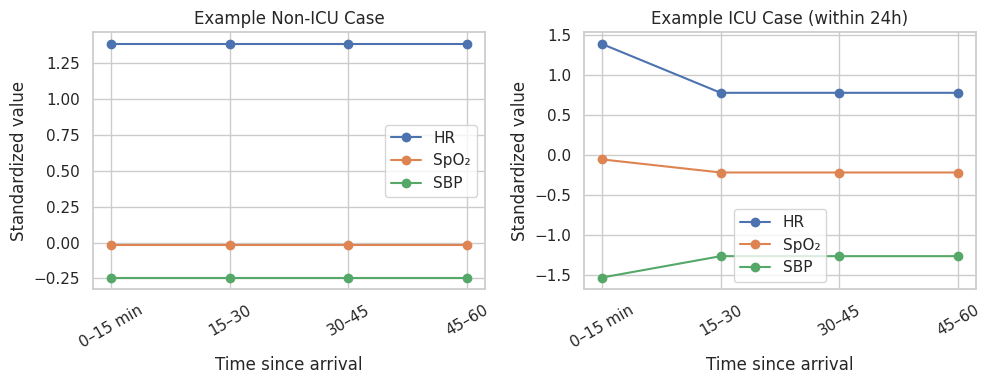

In [ ]:
import random

# pick one positive and one negative example
pos_indices = np.where(y_test_arr == 1)[0]
neg_indices = np.where(y_test_arr == 0)[0]

i_pos = random.choice(pos_indices)
i_neg = random.choice(neg_indices)

example_pos = X_test_s[i_pos]  # shape (T, F)
example_neg = X_test_s[i_neg]

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(time_points, example_neg[:, idx_hr], marker='o', label='HR')
plt.plot(time_points, example_neg[:, idx_o2], marker='o', label='SpO₂')
plt.plot(time_points, example_neg[:, idx_sbp], marker='o', label='SBP')
plt.xticks(time_points, time_labels, rotation=30)
plt.title("Example Non-ICU Case")
plt.xlabel("Time since arrival")
plt.ylabel("Standardized value")
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(time_points, example_pos[:, idx_hr], marker='o', label='HR')
plt.plot(time_points, example_pos[:, idx_o2], marker='o', label='SpO₂')
plt.plot(time_points, example_pos[:, idx_sbp], marker='o', label='SBP')
plt.xticks(time_points, time_labels, rotation=30)
plt.title("Example ICU Case (within 24h)")
plt.xlabel("Time since arrival")
plt.ylabel("Standardized value")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


## Added Curves

In [ ]:
# y_test is already defined from before

# 1. Tabular XGBoost (CALIBRATED) – already computed earlier
prob_xgb_tab_cal = y_test_prob_tab_cal

# 2. Text-only TF–IDF + LogReg – already computed earlier
prob_text = y_prob_text

# 3. Fusion (0.7 tab + 0.3 text) – already computed earlier
prob_fusion = fusion_prob

# 4. GRU time-series – already computed earlier
prob_gru = y_prob_gru
